# Directional Flow Map
## Notebook 9

## Gabriel del Valle
## 10/25/24
## NYC DATA SCIENCE ACADEMY

### For any questions about this project or to request full map videos or datasets, please feel free to reach out on Linkedin: 

   www.linkedin.com/in/gabriel-del-valle-147616152


In this notebook I've revisited the Animated NYC Congestion Zone Traffic Map Analysis to portray the to street and from street relationships in the data and the directional exchanges of volume they represent. My goal was to portray these directional volume relationships using markers systemically placed along the length of each relevant street. These markers both clarify where directional volume flow has been recorded in the Automated Traffic Counts dataset and allow me to use a color gradient to portray the direction of the traffic.

Exchanges of volume between two streets are corresponded to a point on a map (an intersection) by comparing the toStreet and fromStreet values of each intersecting street. An intersection marker is generated for each intersection recorded in the data by comparing geometric intersections and the names of streets where geometric intersections occur in the base_map.geojson dataset.

- In all rows of the Automated Traffic Counts dataset, the flow of traffic volume exchanged between intersections is uni-directional.

- The grey-scale street markers are placed between intersections that have an exchange of volume recorded between them in the Automated Traffic Counts dataset.


The data for connections between intersection markers and street markers, as well as the index of the street markers are generated by markerkey_connections_map2(). 

Street index values indicate the direction of flow: Index values towards 0 connect to "gain_streets" whereas index values at the end of the list connect to "lose_streets".

Greyscale colors are assigned to street markers, normalized to the number of markers between two intersections.

The greyscale colors do not imply volume quantities, as there is not data to support the assignment of specific volumes to the street markers between known intersections. Rather, the greyscale colors are purely meant to indicate the directional flow of the traffic.

While intersection markers could be colored, as they have known to_volume, from_volume, net_volume, absolute_volume, and congestion values per datetime, I chose not to color intersection markers, since intersection markers are most often very near the WktGeom marker that is the source of its data. Thus, allowing the WktGeom markers alone to reflect the volume / congestion values gives clarity and precision to where recorded volumes correspond.


To further develop what I have started here, I could do more to communicate the relationship between intersection markers and WktGeom markers, such as:

- coloring intersection markers (with a nonclashing colormap like blue to purple), to portray the volumes gained or lost at each intersection

- connecting streets between intersection markers and WktGeom markers with street markers if there is a corresponding flow of data between them. Despite that WktGeom markers are rarely perfectly aligned with an intersection (which helps to generate and correspond street markers), a WktGeom marker could be replaced by the nearest intersection marker on the map. This method has been proven to work but not integrated into the current output of this project.


Overall, this new system has advanced my goal of portraying the maximum amount of traffic flow information available in the Automated Traffic Counts dataset in an animated form. Potentially, the system for systemically generating and coordinating markers could be combined with more information on traffic movement patterns to portray a simulation of traffic flow.

---
 
Note that opposed to the previous mapping notebooks in this project, the data is not aggregated. Previously data was aggregated to account for multiple rows per street per datetime, representing multiple segments per street. Each data recording nodes accounts for these segments.

Nodes are colored with a congestion value, like in previous maps, however this is calculated with:

vol per street / max_vol per street

rather than:

avg_vol per street / max_vol per street


---


## sorted_intersection_dates:

Stores all the information which is needed to track the known exchanges of volumes between streets in the OTMD dataset, and correspond these to intersections on the map

Created in the notebook 08_Intersections

Columns:

- datetime
- to_vol 	
- from_vol 	
- total_vol  (really net_volume)	
- street1 	
- SegmentID1 	
- s1_dir 	
- s1_from 	
- s1_to 	
- street2 	
- SegmentID2 	
- s2_dir 	
- s2_from
- s2_to 	
- marker  (coordinates)
- intersection_id 	
- gain_street 	
- lose_street



## Functions:


### generate_markers( )

    Given a street geometry and a marker spacing generates markers for along the street geometry, with the number of markers determined by the street's vertical length.
    
    
### process_street_markers( )

    Given a street name and a marker spacing, calls generate_markers() to generate markers for each geometry value for the given street.
    
    
### markerkey_connection_map2( )

    Given a datetime and a marker spacing, generates marker_data_df, recording connections between intersection markers and street markers, as well as the index of the street markers are generated. Street marker indexes are assigned based on the direction of volume exchanges between streets. Uses process_street_markers to generate street markers for all streets for a given datetime that connect 2 or more intersections.

### map_all_flow_direction2( )

    Plots street markers, intersection markers, and wktGeom markers for a given datetime, coloring street markers based on their directional flow and WktGeom markers based on congestion values. Calls markerkey_connection_map2 to create marker network.
    
### animate_all_flow()

    Given a start row and an end row, querries datetime values shared by both congestion_intersection_dates and OTMD. Calls map_all_flow_direction2() to generate and save maps per the given datetimes.
    

In [2]:
from shapely.wkt import loads
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString, LineString
import re
import os
import cv2
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from shapely import wkt

#### Prepare basic data:

In [3]:
base_map = gpd.read_file('base_map.geojson')

In [4]:
czone_October = pd.read_csv("czone_October.csv")

In [5]:
# Recreate the congestion_streets dataframe with full columns
# And no aggregation
czone_October['datetime'] = pd.to_datetime(czone_October[['year', 'month', 'day', 'hour', 'minute']])

noNA_October = czone_October.dropna(subset=['Vol'])

maxStreetVol_Oct = noNA_October.groupby('street')['Vol'].max().reset_index()
maxStreetVol_Oct.columns = ['street', 'max_volume']
OTMD = pd.merge(noNA_October, maxStreetVol_Oct, on='street')

OTMD['congestion'] = OTMD['Vol'] / OTMD['max_volume']
OTMDdates = OTMD['datetime'].unique()

In [6]:
sorted_intersection_dates = pd.read_csv("sorted_intersection_dates.csv")

inix markers are unused in this project but they store all of the intersections of the street geometries in base_map as well as what the corresponding streets are:

In [8]:
import json
from ast import literal_eval  # To safely evaluate string tuples

with open('inix.json', 'r') as json_file:
    inix_str_keys = json.load(json_file)
    
# Convert string keys back to tuples
inix = {literal_eval(key): value for key, value in inix_str_keys.items()}


Map all wktGeom points in OTMD:

- This plotting reveals that there are WktGeom points beyond the congestion zone influencing the volume counts for streets inside the congestion zone. 

- They could be removed by using the matplotlib axis to select markers based on geometric boundaries. These markers can then be corresponded to rows that can be excluded by OTMD

- It would be best to do this retroactively for the previous notebooks as well. 

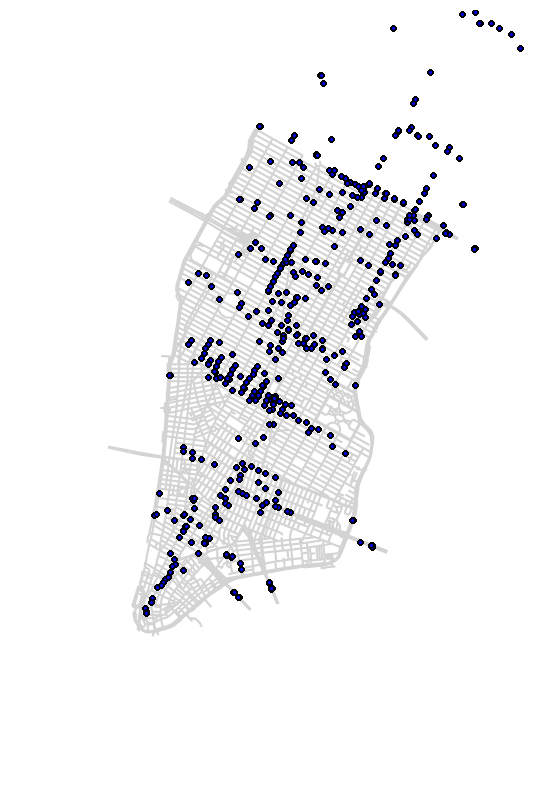

In [57]:
OTMD2 = OTMD.copy()

OTMD2['geometry'] = OTMD2['WktGeom'].apply(wkt.loads)

# Create a GeoDataFrame from OTMD with WktGeom geometries
wkt_gdf = gpd.GeoDataFrame(OTMD2, geometry='geometry')

wkt_gdf.crs = "EPSG:2263"  # Assuming New York State Plane
wkt_gdf = wkt_gdf.to_crs(epsg=4326)  # Convert to WGS84

# Step 3: Plot the basemap and overlay the WktGeom points
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the basemap
base_map.plot(ax=ax, color='lightgray', edgecolor='black')

wkt_gdf.plot(ax=ax, color = 'blue', edgecolor='black', alpha=1.0, legend=False, zorder=2, markersize=10)

ax.set_xlim([-74.04, -73.94])
ax.set_ylim([40.68, 40.79])


# Customize plot
plt.axis('off')

# Show the plot
plt.show()


A custom color spectrum can be used to avoid the middle values (yellow) being dimmer and more difficult to read than high or low values in the matplotlib RgYlGn_r color map:

In [76]:
colors = ["green", "yellow", "red"]  # Simple green to yellow to red gradient
RGcmap = LinearSegmentedColormap.from_list("custom_green_red", colors, N=256)

Assign an abs_vol column to sorted_intersection_dates (reflecting a true total volume, since the total_vol column actually reflects net volume). The maximum absolute volume of a given intersection marker can be used to calculate a congestion value. While potentially useful in the future, this aspect is currently unused:

In [81]:
sorted_intersection_dates['abs_vol'] = sorted_intersection_dates['from_vol'] + sorted_intersection_dates['to_vol']

sorted_intersection_dates[(sorted_intersection_dates['from_vol'] > 0) & (sorted_intersection_dates['to_vol'] > 0)]

,datetime,to_vol,from_vol,total_vol,street1,SegmentID1,s1_dir,s1_from,s1_to,street2,SegmentID2,s2_dir,s2_from,s2_to,marker,intersection_id,gain_street,lose_street,abs_vol
13728,2017-10-13 00:00:00,553.0,240.0,313.0,2 AVENUE,36375.0,SB,EAST 61 STREET,ASTORIA LINE,EAST 58 STREET,165548.0,EB,3 AVENUE,2 AVENUE,POINT (-73.96480079595024 40.759982138903275),36375.0-165548.0,2 AVENUE,EAST 58 STREET,793.0
13735,2017-10-13 00:15:00,499.0,214.0,285.0,2 AVENUE,36375.0,SB,EAST 61 STREET,ASTORIA LINE,EAST 58 STREET,165548.0,EB,3 AVENUE,2 AVENUE,POINT (-73.96480079595024 40.759982138903275),36375.0-165548.0,2 AVENUE,EAST 58 STREET,713.0
13742,2017-10-13 00:30:00,505.0,212.0,293.0,2 AVENUE,36375.0,SB,EAST 61 STREET,ASTORIA LINE,EAST 58 STREET,165548.0,EB,3 AVENUE,2 AVENUE,POINT (-73.96480079595024 40.759982138903275),36375.0-165548.0,2 AVENUE,EAST 58 STREET,717.0
13749,2017-10-13 00:45:00,496.0,213.0,283.0,2 AVENUE,36375.0,SB,EAST 61 STREET,ASTORIA LINE,EAST 58 STREET,165548.0,EB,3 AVENUE,2 AVENUE,POINT (-73.96480079595024 40.759982138903275),36375.0-165548.0,2 AVENUE,EAST 58 STREET,709.0
13756,2017-10-13 01:00:00,487.0,178.0,309.0,2 AVENUE,36375.0,SB,EAST 61 STREET,ASTORIA LINE,EAST 58 STREET,165548.0,EB,3 AVENUE,2 AVENUE,POINT (-73.96480079595024 40.759982138903275),36375.0-165548.0,2 AVENUE,EAST 58 STREET,665.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110550,2019-10-29 23:30:00,234.0,226.0,8.0,2 AVENUE,35944.0,SB,EAST 43 STREET,EAST 42 STREET,EAST 42 STREET,35945.0,WB,2 AVENUE,FLUSHING LINE,POINT (-73.9722037214914 40.74982300502161),35944.0-35945.0,EAST 42 STREET,2 AVENUE,460.0
110551,2019-10-29 23:30:00,85.0,363.0,-278.0,2 AVENUE,36116.0,SB,EAST 48 STREET,EAST 49 STREET,EAST 49 STREET,36127.0,WB,2 AVENUE,1 AVENUE,POINT (-73.96897803741389 40.75425053544146),36116.0-36127.0,EAST 49 STREET,2 AVENUE,448.0
110575,2019-10-29 23:45:00,156.0,231.0,-75.0,2 AVENUE,33290.0,SB,EAST 24 STREET,EAST 23 STREET,EAST 23 STREET,33291.0,EB,2 AVENUE,1 AVENUE,POINT (-73.98090534080625 40.73788616382121),33290.0-33291.0,EAST 23 STREET,2 AVENUE,387.0
110578,2019-10-29 23:45:00,218.0,223.0,-5.0,2 AVENUE,35944.0,SB,EAST 43 STREET,EAST 42 STREET,EAST 42 STREET,35945.0,WB,2 AVENUE,FLUSHING LINE,POINT (-73.9722037214914 40.74982300502161),35944.0-35945.0,EAST 42 STREET,2 AVENUE,441.0


In [87]:
maxStreetVol_int = sorted_intersection_dates.groupby('intersection_id')['abs_vol'].max().reset_index()
maxStreetVol_int.columns = ['intersection_id', 'max_volume']
congestion_intersection_dates = pd.merge(sorted_intersection_dates, maxStreetVol_int, on='intersection_id')

congestion_intersection_dates['congestion'] = congestion_intersection_dates['abs_vol'] / congestion_intersection_dates['max_volume']

congestion_intersection_dates

,datetime,to_vol,from_vol,total_vol,street1,SegmentID1,s1_dir,s1_from,s1_to,street2,...,s2_dir,s2_from,s2_to,marker,intersection_id,gain_street,lose_street,abs_vol,max_volume,congestion
0,2016-10-01 00:00:00,0.0,69.0,-69.0,CENTRE STREET,32337.0,NB,HOWARD STREET,GRAND STREET,GRAND STREET,...,EB,BROADWAY,CROSBY STREET,POINT (-73.9985232734708 40.719785146159396),32337.0-32327.0,GRAND STREET,CENTRE STREET,69.0,196.0,0.352041
1,2016-10-01 00:00:00,0.0,92.0,-92.0,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,LAFAYETTE STREET,...,SB,HOWARD STREET,GRAND STREET,POINT (-73.99906145014921 40.72004430035703),32327.0-32332.0,GRAND STREET,LAFAYETTE STREET,92.0,139.0,0.661871
2,2016-10-01 00:15:00,0.0,74.0,-74.0,CENTRE STREET,32337.0,NB,HOWARD STREET,GRAND STREET,GRAND STREET,...,EB,BROADWAY,CROSBY STREET,POINT (-73.9985232734708 40.719785146159396),32337.0-32327.0,GRAND STREET,CENTRE STREET,74.0,196.0,0.377551
3,2016-10-01 00:15:00,0.0,81.0,-81.0,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,LAFAYETTE STREET,...,SB,HOWARD STREET,GRAND STREET,POINT (-73.99906145014921 40.72004430035703),32327.0-32332.0,GRAND STREET,LAFAYETTE STREET,81.0,139.0,0.582734
4,2016-10-01 00:30:00,0.0,77.0,-77.0,CENTRE STREET,32337.0,NB,HOWARD STREET,GRAND STREET,GRAND STREET,...,EB,BROADWAY,CROSBY STREET,POINT (-73.9985232734708 40.719785146159396),32337.0-32327.0,GRAND STREET,CENTRE STREET,77.0,196.0,0.392857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111829,2019-10-31 04:00:00,0.0,10.0,-10.0,WEST 18 STREET,32463.0,EB,8 AVENUE,9 AVENUE,9 AVENUE,...,SB,WEST 40 STREET,WEST 39 STREET,POINT (-74.00354201925023 40.74344827908281),32463.0-33699.0,9 AVENUE,WEST 18 STREET,10.0,120.0,0.083333
111830,2019-10-31 04:00:00,0.0,72.0,-72.0,5 AVENUE,32813.0,SB,EAST 17 STREET,EAST 18 STREET,EAST 18 STREET,...,EB,BROADWAY,PARK AVENUE SOUTH,POINT (-73.99179768837975 40.73850365378348),32813.0-164329.0,EAST 18 STREET,5 AVENUE,72.0,380.0,0.189474
111831,2019-10-31 04:15:00,0.0,54.0,-54.0,5 AVENUE,32813.0,SB,EAST 17 STREET,EAST 18 STREET,EAST 18 STREET,...,EB,BROADWAY,PARK AVENUE SOUTH,POINT (-73.99179768837975 40.73850365378348),32813.0-164329.0,EAST 18 STREET,5 AVENUE,54.0,380.0,0.142105
111832,2019-10-31 04:30:00,0.0,50.0,-50.0,5 AVENUE,32813.0,SB,EAST 17 STREET,EAST 18 STREET,EAST 18 STREET,...,EB,BROADWAY,PARK AVENUE SOUTH,POINT (-73.99179768837975 40.73850365378348),32813.0-164329.0,EAST 18 STREET,5 AVENUE,50.0,380.0,0.131579


# The following is where the Directional Flow animation is created:

In [155]:
congestion_intersection_dates['marker'] = congestion_intersection_dates['marker'].apply(loads)

In [249]:
def generate_markers(geometry, marker_spacing=10):
    """
    Divide a LineString or MultiLineString geometry into evenly spaced markers based on street length.
    
    :param geometry: LineString or MultiLineString geometry of the street
    :param marker_spacing: Distance between each marker (in units consistent with the geometry's CRS)
    :return: List of Point geometries for each marker
    """
    markers = []
    
    if isinstance(geometry, MultiLineString):
        for line in geometry.geoms:  # Iterate over each LineString in the MultiLineString
            markers.extend(generate_markers(line, marker_spacing))
    
    # If the geometry is a LineString, process it normally
    elif isinstance(geometry, LineString):
        length = geometry.length
        num_markers = max(int(length // marker_spacing) + 1, 2)  # Ensure at least 2 markers (start and end)

        distances = [i / (num_markers - 1) * length for i in range(num_markers)]
        markers.extend([geometry.interpolate(distance) for distance in distances])

    else:
        raise TypeError(f"Expected LineString or MultiLineString geometry, but got {type(geometry)}")

    return markers

In [247]:
def process_street_markers(street_name, marker_spacing=10):
    """
    Generate markers for a street based on its geometry.
    
    :param street_name: The name of the street for which to generate markers
    :param marker_spacing: The distance between each marker
    :return: List of generated markers for the street
    """
    street_map = base_map[base_map['st_name'] == street_name]
    street_markers = []

    # Loop through each geometry for the street
    for geom in street_map['geometry'].unique():
        try:
            # Generate markers for each unique geometry segment
            markers = generate_markers(geom, marker_spacing)

            # Add markers to the list
            street_markers.extend(markers)
        except Exception as e:
            print(f"Error processing geometry for {street_name}: {e}")
    
    return street_markers

### For a given datetime:
### Generate street markers between intersections that share the same street
### Create an index identifying the order of the markers between two known intersections, indicating direction of traffic flow (towards gain street or lose street)
### Index connections between street markers and intersections
### Used by map_all_flow_directions and map_all_flow_directions2 to plot street markers

In [409]:
def masterkey_connections_map2(datetime, marker_spacing=10):
    """
    Generate and plot all street markers for intersection markers, assigning `street_index` 
    based on flow direction from gain_street to lose_street.
    """
    
    time_slice = congestion_intersection_dates[congestion_intersection_dates['datetime'] == datetime]
    
    marker_data = []
    
    processed_streets = set()

    street_markers_info = {}

    # Step 2: Loop through each intersection marker and check if it shares a street with another intersection marker
    for i, marker_data_row in time_slice.iterrows():
        marker1 = marker_data_row['marker']

        for j, compare_marker_data_row in time_slice.iterrows():
            if i == j:
                continue  # Skip the same marker

            marker2 = compare_marker_data_row['marker']
            shared_street = None

            # Identify the shared street
            if marker_data_row['street1'] == compare_marker_data_row['street1'] or \
               marker_data_row['street1'] == compare_marker_data_row['street2']:
                shared_street = marker_data_row['street1']
            elif marker_data_row['street2'] == compare_marker_data_row['street1'] or \
                 marker_data_row['street2'] == compare_marker_data_row['street2']:
                shared_street = marker_data_row['street2']

            # Generate street markers if shared street not processed
            if shared_street and shared_street not in processed_streets:
                street_markers = process_street_markers(shared_street, marker_spacing)
                processed_streets.add(shared_street)

                # Determine the flow direction for `street_index` ordering
                if marker_data_row['gain_street'] == shared_street:
                    ordered_markers = enumerate(street_markers)  # Normal order
                else:
                    ordered_markers = enumerate(reversed(street_markers))  # Reversed order

                # Step 3: Store the street markers and information about their connections in master key
                for idx, marker in ordered_markers:
                    marker_key = f"{shared_street}_{idx}"

                    # Initialize details for each marker in master key
                    if marker_key not in street_markers_info:
                        street_markers_info[marker_key] = {
                            'street': shared_street,
                            'marker_geom': marker,
                            'connections': [],
                            'is_intersection': False
                        }

                    # Add connection info based on the position of the marker
                    if any(matching_marker.marker.equals(marker) for matching_marker in time_slice.itertuples()):
                        street_markers_info[marker_key]['is_intersection'] = True
                    if idx == 0:
                        street_markers_info[marker_key]['connections'].append(marker1)
                    elif idx == len(street_markers) - 1:
                        street_markers_info[marker_key]['connections'].append(marker2)
                    else:
                        street_markers_info[marker_key]['connections'].append((marker1, marker2))
    
    # Organize markers and connections
    for key, value in street_markers_info.items():
        marker_data.append({
            'street': value['street'],
            'marker_geom': value['marker_geom'],
            'connections': value['connections'],
            'street_index': int(key.split('_')[-1]),  # `street_index` based on adjusted direction
            'is_intersection': value['is_intersection']
        })

    marker_data_df = pd.DataFrame(marker_data)
    return marker_data_df


### Identify datetimes shared by both congestion_intersection_dates and OTMD (intersection data and WktGeom data) for querring relevant datetimes in the following function:

In [481]:
shared_datetimes = [date for date in cid_dates if date in OTMDdates]



len(shared_datetimes)

8276

### Plot a Direction Traffic_Flow_Map in the notebook without saving it:

In [410]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

def map_all_flow_direction(datetime, marker_spacing=10):
    """
    Plot street markers for intersections, emphasizing directional flow with grayscale and prioritizing intersection markers.
    """
    # Generate the markers and connections using the modified masterkey_connections_map
    marker_data_df = masterkey_connections_map2(datetime, marker_spacing)
    
    cid_data = congestion_intersection_dates[congestion_intersection_dates['datetime'] == datetime]
    
    plotted_wkts = []
    

    fig, ax = plt.subplots(figsize=(10, 10))
    base_map.plot(ax=ax, color='lightgray', edgecolor='none')  # Plot base map
    
    
    cmap = cm.binary
    # Loop through each street's markers
    if len(marker_data_df) > 0:
        for street, markers_group in marker_data_df.groupby('street'):
            markers_group = markers_group.sort_values('street_index')
            num_markers = len(markers_group)


            # Normalize grayscale based on position along the street segment
            norm = Normalize(vmin=0, vmax=num_markers - 1)
            for i, (_, row) in enumerate(markers_group.iterrows()):
                # Darker (close to 1) near gain street, lighter (close to 0) near lose street
                color = cmap(norm(i)) 
                ax.scatter(row['marker_geom'].x, row['marker_geom'].y, color=color, 
                           edgecolor='black', linewidth = 0.2, s=15, zorder=2, alpha=1)
                
    
    OTMDdata = OTMD[OTMD['datetime'] == datetime]

    # Create a GeoDataFrame from OTMD with WktGeom geometries
    wkt_gdf = gpd.GeoDataFrame(OTMDdata, geometry='geometry')

    wkt_gdf.crs = "EPSG:2263"  # Assuming New York State Plane
    wkt_gdf = wkt_gdf.to_crs(epsg=4326)  # Convert to WGS84
    
    wkt_gdf.plot(ax=ax, column='congestion', 
                 cmap=RGcmap, edgecolor='black', linewidth = 0.2, alpha=1.0, legend=False, zorder=3, markersize=15)
            
            
                
    
    
    # Customize plot
    ax.set_axis_off()
    ax.set_xlim([-74.04, -73.94])  # Adjust x-limits for NYC
    ax.set_ylim([40.68, 40.79])     # Adjust y-limits for NYC
    ax.set_title(f"Traffic Flow for {datetime}")

    plt.show()
    plt.close()

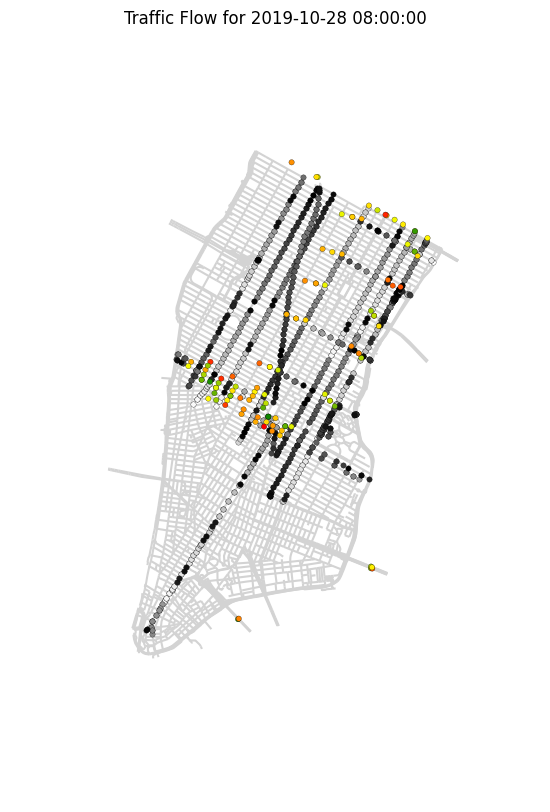

In [411]:
# Example usage
datetime = shared_datetimes[8000]
map_all_flow_direction(datetime)

### Saves the map to the given output_directory rather than printing it inline:

In [425]:
def map_all_flow_direction2(datetime, frame_num, output_dir, marker_spacing=10):
    """
    Plot street markers for intersections, emphasizing directional flow with grayscale and prioritizing intersection markers.
    """
    # Generate the markers and connections using the modified masterkey_connections_map
    marker_data_df = masterkey_connections_map2(datetime, marker_spacing)
    
    cid_data = congestion_intersection_dates[congestion_intersection_dates['datetime'] == datetime]
    
    plotted_wkts = []
    

    fig, ax = plt.subplots(figsize=(10, 10))
    base_map.plot(ax=ax, color='lightgray', edgecolor='none')  # Plot base map
    
    
    cmap = cm.binary
    # Loop through each street's markers
    if len(marker_data_df) > 0:
        for street, markers_group in marker_data_df.groupby('street'):
            markers_group = markers_group.sort_values('street_index')
            num_markers = len(markers_group)


            # Normalize grayscale based on position along the street segment
            norm = Normalize(vmin=0, vmax=num_markers - 1)
            for i, (_, row) in enumerate(markers_group.iterrows()):
                # Darker (close to 1) near gain street, lighter (close to 0) near lose street
                color = cmap(norm(i)) # if not row['is_intersection'] else 'blue'
                ax.scatter(row['marker_geom'].x, row['marker_geom'].y, color=color, 
                           edgecolor='black', linewidth = 0.2, s=15, zorder=2, alpha=1)
                
    
    OTMDdata = OTMD[OTMD['datetime'] == datetime]

    # Create a GeoDataFrame from OTMD with WktGeom geometries
    wkt_gdf = gpd.GeoDataFrame(OTMDdata, geometry='geometry')

    wkt_gdf.crs = "EPSG:2263"  # Assuming New York State Plane
    wkt_gdf = wkt_gdf.to_crs(epsg=4326)  # Convert to WGS84
    
    wkt_gdf.plot(ax=ax, column='congestion', 
                 cmap=RGcmap, edgecolor='black', linewidth = 0.2, alpha=1.0, legend=False, zorder=3, markersize=15)
            
            
                
    
    
    # Customize plot
    ax.set_axis_off()
    ax.set_xlim([-74.04, -73.94])  # Adjust x-limits for NYC
    ax.set_ylim([40.68, 40.79])     # Adjust y-limits for NYC
    ax.set_title(f"{datetime}")
    
    # Save the frame as an image
    frame_filename = f"{datetime}_{frame_num:03d}.png"
    plt.savefig(os.path.join(output_dir, frame_filename), bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close(fig)  # Close the figure to free up memory
    
    print(f"Saved frame {frame_num + 1}: {frame_filename}")
    
    return frame_filename
    #plt.show()


### Querry datetimes using index of a list of datetimes

### Use datetimes to plot Direction Flow Maps

### Save all created filenames for further processing into video:

In [426]:
def animate_all_flow(start_datetime_index, end_datetime_index, datetime_list, output_dir):

    file_names = []
    
    counter = start_datetime_index
    

    # Ensure start and end indices are within bounds
    if start_datetime_index < 0 or end_datetime_index >= len(datetime_list):
        raise ValueError("Datetime indices are out of bounds.")
    
    # Get the list of datetimes to generate frames for
    datetime_range = datetime_list[start_datetime_index:end_datetime_index + 1]

    # Step 2: Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    

    # Step 3: Loop through each datetime and generate frames
    for date in datetime_range:

        # Plot the traffic flow using simulate_traffic_flow
        file_name = map_all_flow_direction2(date, counter, output_dir)
        
        counter += 1

        
        file_names.append(file_name)
        

    print(f"All frames saved in directory: {output_dir}")
    return file_names

### Segment processing of all dates into 1000 querries at a time (or less depending on your computer) to avoid overwhelming the kernel:

In [427]:
allflow1000 = animate_all_flow(0, 1000, shared_datetimes, 'all_flow3')

Saved frame 1: 2016-10-01 00:00:00_000.png
Saved frame 2: 2016-10-01 00:15:00_001.png
Saved frame 3: 2016-10-01 00:30:00_002.png
Saved frame 4: 2016-10-01 00:45:00_003.png
Saved frame 5: 2016-10-01 01:00:00_004.png
Saved frame 6: 2016-10-01 01:15:00_005.png
Saved frame 7: 2016-10-01 01:30:00_006.png
Saved frame 8: 2016-10-01 01:45:00_007.png
Saved frame 9: 2016-10-01 02:00:00_008.png
Saved frame 10: 2016-10-01 02:15:00_009.png
Saved frame 11: 2016-10-01 02:30:00_010.png
Saved frame 12: 2016-10-01 02:45:00_011.png
Saved frame 13: 2016-10-01 03:00:00_012.png
Saved frame 14: 2016-10-01 03:15:00_013.png
Saved frame 15: 2016-10-01 03:30:00_014.png
Saved frame 16: 2016-10-01 03:45:00_015.png
Saved frame 17: 2016-10-01 04:00:00_016.png
Saved frame 18: 2016-10-01 04:15:00_017.png
Saved frame 19: 2016-10-01 04:30:00_018.png
Saved frame 20: 2016-10-01 04:45:00_019.png
Saved frame 21: 2016-10-01 05:00:00_020.png
Saved frame 22: 2016-10-01 05:15:00_021.png
Saved frame 23: 2016-10-01 05:30:00_022.p

Saved frame 186: 2016-10-02 22:15:00_185.png
Saved frame 187: 2016-10-02 22:30:00_186.png
Saved frame 188: 2016-10-02 22:45:00_187.png
Saved frame 189: 2016-10-02 23:00:00_188.png
Saved frame 190: 2016-10-02 23:15:00_189.png
Saved frame 191: 2016-10-02 23:30:00_190.png
Saved frame 192: 2016-10-02 23:45:00_191.png
Saved frame 193: 2016-10-03 00:00:00_192.png
Saved frame 194: 2016-10-03 00:15:00_193.png
Saved frame 195: 2016-10-03 00:30:00_194.png
Saved frame 196: 2016-10-03 00:45:00_195.png
Saved frame 197: 2016-10-03 01:00:00_196.png
Saved frame 198: 2016-10-03 01:15:00_197.png
Saved frame 199: 2016-10-03 01:30:00_198.png
Saved frame 200: 2016-10-03 01:45:00_199.png
Saved frame 201: 2016-10-03 02:00:00_200.png
Saved frame 202: 2016-10-03 02:15:00_201.png
Saved frame 203: 2016-10-03 02:30:00_202.png
Saved frame 204: 2016-10-03 02:45:00_203.png
Saved frame 205: 2016-10-03 03:00:00_204.png
Saved frame 206: 2016-10-03 03:15:00_205.png
Saved frame 207: 2016-10-03 03:30:00_206.png
Saved fram

Saved frame 369: 2016-10-04 20:00:00_368.png
Saved frame 370: 2016-10-04 20:15:00_369.png
Saved frame 371: 2016-10-04 20:30:00_370.png
Saved frame 372: 2016-10-04 20:45:00_371.png
Saved frame 373: 2016-10-04 21:00:00_372.png
Saved frame 374: 2016-10-04 21:15:00_373.png
Saved frame 375: 2016-10-04 21:30:00_374.png
Saved frame 376: 2016-10-04 21:45:00_375.png
Saved frame 377: 2016-10-04 22:00:00_376.png
Saved frame 378: 2016-10-04 22:15:00_377.png
Saved frame 379: 2016-10-04 22:30:00_378.png
Saved frame 380: 2016-10-04 22:45:00_379.png
Saved frame 381: 2016-10-04 23:00:00_380.png
Saved frame 382: 2016-10-04 23:15:00_381.png
Saved frame 383: 2016-10-04 23:30:00_382.png
Saved frame 384: 2016-10-04 23:45:00_383.png
Saved frame 385: 2016-10-05 00:00:00_384.png
Saved frame 386: 2016-10-05 00:15:00_385.png
Saved frame 387: 2016-10-05 00:30:00_386.png
Saved frame 388: 2016-10-05 00:45:00_387.png
Saved frame 389: 2016-10-05 01:00:00_388.png
Saved frame 390: 2016-10-05 01:15:00_389.png
Saved fram

Saved frame 552: 2016-10-24 17:45:00_551.png
Saved frame 553: 2016-10-24 18:00:00_552.png
Saved frame 554: 2016-10-24 18:15:00_553.png
Saved frame 555: 2016-10-24 18:30:00_554.png
Saved frame 556: 2016-10-24 18:45:00_555.png
Saved frame 557: 2016-10-24 19:00:00_556.png
Saved frame 558: 2016-10-24 19:15:00_557.png
Saved frame 559: 2016-10-24 19:30:00_558.png
Saved frame 560: 2016-10-24 19:45:00_559.png
Saved frame 561: 2016-10-24 20:00:00_560.png
Saved frame 562: 2016-10-24 20:15:00_561.png
Saved frame 563: 2016-10-24 20:30:00_562.png
Saved frame 564: 2016-10-24 20:45:00_563.png
Saved frame 565: 2016-10-24 21:00:00_564.png
Saved frame 566: 2016-10-24 21:15:00_565.png
Saved frame 567: 2016-10-24 21:30:00_566.png
Saved frame 568: 2016-10-24 21:45:00_567.png
Saved frame 569: 2016-10-24 22:00:00_568.png
Saved frame 570: 2016-10-24 22:15:00_569.png
Saved frame 571: 2016-10-24 22:30:00_570.png
Saved frame 572: 2016-10-24 22:45:00_571.png
Saved frame 573: 2016-10-24 23:00:00_572.png
Saved fram

Saved frame 735: 2016-10-26 15:30:00_734.png
Saved frame 736: 2016-10-26 15:45:00_735.png
Saved frame 737: 2016-10-26 16:00:00_736.png
Saved frame 738: 2016-10-26 16:15:00_737.png
Saved frame 739: 2016-10-26 16:30:00_738.png
Saved frame 740: 2016-10-26 16:45:00_739.png
Saved frame 741: 2016-10-26 17:00:00_740.png
Saved frame 742: 2016-10-26 17:15:00_741.png
Saved frame 743: 2016-10-26 17:30:00_742.png
Saved frame 744: 2016-10-26 17:45:00_743.png
Saved frame 745: 2016-10-26 18:00:00_744.png
Saved frame 746: 2016-10-26 18:15:00_745.png
Saved frame 747: 2016-10-26 18:30:00_746.png
Saved frame 748: 2016-10-26 18:45:00_747.png
Saved frame 749: 2016-10-26 19:00:00_748.png
Saved frame 750: 2016-10-26 19:15:00_749.png
Saved frame 751: 2016-10-26 19:30:00_750.png
Saved frame 752: 2016-10-26 19:45:00_751.png
Saved frame 753: 2016-10-26 20:00:00_752.png
Saved frame 754: 2016-10-26 20:15:00_753.png
Saved frame 755: 2016-10-26 20:30:00_754.png
Saved frame 756: 2016-10-26 20:45:00_755.png
Saved fram

Saved frame 918: 2016-10-28 13:15:00_917.png
Saved frame 919: 2016-10-28 13:30:00_918.png
Saved frame 920: 2016-10-28 13:45:00_919.png
Saved frame 921: 2016-10-28 14:00:00_920.png
Saved frame 922: 2016-10-28 14:15:00_921.png
Saved frame 923: 2016-10-28 14:30:00_922.png
Saved frame 924: 2016-10-28 14:45:00_923.png
Saved frame 925: 2016-10-28 15:00:00_924.png
Saved frame 926: 2016-10-28 15:15:00_925.png
Saved frame 927: 2016-10-28 15:30:00_926.png
Saved frame 928: 2016-10-28 15:45:00_927.png
Saved frame 929: 2016-10-28 16:00:00_928.png
Saved frame 930: 2016-10-28 16:15:00_929.png
Saved frame 931: 2016-10-28 16:30:00_930.png
Saved frame 932: 2016-10-28 16:45:00_931.png
Saved frame 933: 2016-10-28 17:00:00_932.png
Saved frame 934: 2016-10-28 17:15:00_933.png
Saved frame 935: 2016-10-28 17:30:00_934.png
Saved frame 936: 2016-10-28 17:45:00_935.png
Saved frame 937: 2016-10-28 18:00:00_936.png
Saved frame 938: 2016-10-28 18:15:00_937.png
Saved frame 939: 2016-10-28 18:30:00_938.png
Saved fram

In [428]:
allflow2000 = animate_all_flow(1001, 2000, shared_datetimes, 'all_flow3')

Saved frame 1002: 2016-10-29 10:15:00_1001.png
Saved frame 1003: 2016-10-29 10:30:00_1002.png
Saved frame 1004: 2016-10-29 10:45:00_1003.png
Saved frame 1005: 2016-10-29 11:00:00_1004.png
Saved frame 1006: 2016-10-29 11:15:00_1005.png
Saved frame 1007: 2016-10-29 11:30:00_1006.png
Saved frame 1008: 2016-10-29 11:45:00_1007.png
Saved frame 1009: 2016-10-29 12:00:00_1008.png
Saved frame 1010: 2016-10-29 12:15:00_1009.png
Saved frame 1011: 2016-10-29 12:30:00_1010.png
Saved frame 1012: 2016-10-29 12:45:00_1011.png
Saved frame 1013: 2016-10-29 13:00:00_1012.png
Saved frame 1014: 2016-10-29 13:15:00_1013.png
Saved frame 1015: 2016-10-29 13:30:00_1014.png
Saved frame 1016: 2016-10-29 13:45:00_1015.png
Saved frame 1017: 2016-10-29 14:00:00_1016.png
Saved frame 1018: 2016-10-29 14:15:00_1017.png
Saved frame 1019: 2016-10-29 14:30:00_1018.png
Saved frame 1020: 2016-10-29 14:45:00_1019.png
Saved frame 1021: 2016-10-29 15:00:00_1020.png
Saved frame 1022: 2016-10-29 15:15:00_1021.png
Saved frame 1

Saved frame 1177: 2017-10-01 06:00:00_1176.png
Saved frame 1178: 2017-10-01 06:15:00_1177.png
Saved frame 1179: 2017-10-01 06:30:00_1178.png
Saved frame 1180: 2017-10-01 06:45:00_1179.png
Saved frame 1181: 2017-10-01 07:00:00_1180.png
Saved frame 1182: 2017-10-01 07:15:00_1181.png
Saved frame 1183: 2017-10-01 07:30:00_1182.png
Saved frame 1184: 2017-10-01 07:45:00_1183.png
Saved frame 1185: 2017-10-01 08:00:00_1184.png
Saved frame 1186: 2017-10-01 08:15:00_1185.png
Saved frame 1187: 2017-10-01 08:30:00_1186.png
Saved frame 1188: 2017-10-01 08:45:00_1187.png
Saved frame 1189: 2017-10-01 09:00:00_1188.png
Saved frame 1190: 2017-10-01 09:15:00_1189.png
Saved frame 1191: 2017-10-01 09:30:00_1190.png
Saved frame 1192: 2017-10-01 09:45:00_1191.png
Saved frame 1193: 2017-10-01 10:00:00_1192.png
Saved frame 1194: 2017-10-01 10:15:00_1193.png
Saved frame 1195: 2017-10-01 10:30:00_1194.png
Saved frame 1196: 2017-10-01 10:45:00_1195.png
Saved frame 1197: 2017-10-01 11:00:00_1196.png
Saved frame 1

Saved frame 1352: 2017-10-03 01:45:00_1351.png
Saved frame 1353: 2017-10-03 02:00:00_1352.png
Saved frame 1354: 2017-10-03 02:15:00_1353.png
Saved frame 1355: 2017-10-03 02:30:00_1354.png
Saved frame 1356: 2017-10-03 02:45:00_1355.png
Saved frame 1357: 2017-10-03 03:00:00_1356.png
Saved frame 1358: 2017-10-03 03:15:00_1357.png
Saved frame 1359: 2017-10-03 03:30:00_1358.png
Saved frame 1360: 2017-10-03 03:45:00_1359.png
Saved frame 1361: 2017-10-03 04:00:00_1360.png
Saved frame 1362: 2017-10-03 04:15:00_1361.png
Saved frame 1363: 2017-10-03 04:30:00_1362.png
Saved frame 1364: 2017-10-03 04:45:00_1363.png
Saved frame 1365: 2017-10-03 05:00:00_1364.png
Saved frame 1366: 2017-10-03 05:15:00_1365.png
Saved frame 1367: 2017-10-03 05:30:00_1366.png
Saved frame 1368: 2017-10-03 05:45:00_1367.png
Saved frame 1369: 2017-10-03 06:00:00_1368.png
Saved frame 1370: 2017-10-03 06:15:00_1369.png
Saved frame 1371: 2017-10-03 06:30:00_1370.png
Saved frame 1372: 2017-10-03 06:45:00_1371.png
Saved frame 1

Saved frame 1527: 2017-10-04 21:30:00_1526.png
Saved frame 1528: 2017-10-04 21:45:00_1527.png
Saved frame 1529: 2017-10-04 22:00:00_1528.png
Saved frame 1530: 2017-10-04 22:15:00_1529.png
Saved frame 1531: 2017-10-04 22:30:00_1530.png
Saved frame 1532: 2017-10-04 22:45:00_1531.png
Saved frame 1533: 2017-10-04 23:00:00_1532.png
Saved frame 1534: 2017-10-04 23:15:00_1533.png
Saved frame 1535: 2017-10-04 23:30:00_1534.png
Saved frame 1536: 2017-10-04 23:45:00_1535.png
Saved frame 1537: 2017-10-05 00:00:00_1536.png
Saved frame 1538: 2017-10-05 00:15:00_1537.png
Saved frame 1539: 2017-10-05 00:30:00_1538.png
Saved frame 1540: 2017-10-05 00:45:00_1539.png
Saved frame 1541: 2017-10-05 01:00:00_1540.png
Saved frame 1542: 2017-10-05 01:15:00_1541.png
Saved frame 1543: 2017-10-05 01:30:00_1542.png
Saved frame 1544: 2017-10-05 01:45:00_1543.png
Saved frame 1545: 2017-10-05 02:00:00_1544.png
Saved frame 1546: 2017-10-05 02:15:00_1545.png
Saved frame 1547: 2017-10-05 02:30:00_1546.png
Saved frame 1

Saved frame 1702: 2017-10-06 17:15:00_1701.png
Saved frame 1703: 2017-10-06 17:30:00_1702.png
Saved frame 1704: 2017-10-06 17:45:00_1703.png
Saved frame 1705: 2017-10-06 18:00:00_1704.png
Saved frame 1706: 2017-10-06 18:15:00_1705.png
Saved frame 1707: 2017-10-06 18:30:00_1706.png
Saved frame 1708: 2017-10-06 18:45:00_1707.png
Saved frame 1709: 2017-10-06 19:00:00_1708.png
Saved frame 1710: 2017-10-06 19:15:00_1709.png
Saved frame 1711: 2017-10-06 19:30:00_1710.png
Saved frame 1712: 2017-10-06 19:45:00_1711.png
Saved frame 1713: 2017-10-06 20:00:00_1712.png
Saved frame 1714: 2017-10-06 20:15:00_1713.png
Saved frame 1715: 2017-10-06 20:30:00_1714.png
Saved frame 1716: 2017-10-06 20:45:00_1715.png
Saved frame 1717: 2017-10-06 21:00:00_1716.png
Saved frame 1718: 2017-10-06 21:15:00_1717.png
Saved frame 1719: 2017-10-06 21:30:00_1718.png
Saved frame 1720: 2017-10-06 21:45:00_1719.png
Saved frame 1721: 2017-10-06 22:00:00_1720.png
Saved frame 1722: 2017-10-06 22:15:00_1721.png
Saved frame 1

Saved frame 1877: 2017-10-08 13:00:00_1876.png
Saved frame 1878: 2017-10-08 13:15:00_1877.png
Saved frame 1879: 2017-10-08 13:30:00_1878.png
Saved frame 1880: 2017-10-08 13:45:00_1879.png
Saved frame 1881: 2017-10-08 14:00:00_1880.png
Saved frame 1882: 2017-10-08 14:15:00_1881.png
Saved frame 1883: 2017-10-08 14:30:00_1882.png
Saved frame 1884: 2017-10-08 14:45:00_1883.png
Saved frame 1885: 2017-10-08 15:00:00_1884.png
Saved frame 1886: 2017-10-08 15:15:00_1885.png
Saved frame 1887: 2017-10-08 15:30:00_1886.png
Saved frame 1888: 2017-10-08 15:45:00_1887.png
Saved frame 1889: 2017-10-08 16:00:00_1888.png
Saved frame 1890: 2017-10-08 16:15:00_1889.png
Saved frame 1891: 2017-10-08 16:30:00_1890.png
Saved frame 1892: 2017-10-08 16:45:00_1891.png
Saved frame 1893: 2017-10-08 17:00:00_1892.png
Saved frame 1894: 2017-10-08 17:15:00_1893.png
Saved frame 1895: 2017-10-08 17:30:00_1894.png
Saved frame 1896: 2017-10-08 17:45:00_1895.png
Saved frame 1897: 2017-10-08 18:00:00_1896.png
Saved frame 1

In [429]:
allflow3000 = animate_all_flow(2001, 3000, shared_datetimes, 'all_flow3')

Saved frame 2002: 2017-10-09 20:15:00_2001.png
Saved frame 2003: 2017-10-09 20:30:00_2002.png
Saved frame 2004: 2017-10-09 20:45:00_2003.png
Saved frame 2005: 2017-10-09 21:00:00_2004.png
Saved frame 2006: 2017-10-09 21:15:00_2005.png
Saved frame 2007: 2017-10-09 21:30:00_2006.png
Saved frame 2008: 2017-10-09 21:45:00_2007.png
Saved frame 2009: 2017-10-09 22:00:00_2008.png
Saved frame 2010: 2017-10-09 22:15:00_2009.png
Saved frame 2011: 2017-10-09 22:30:00_2010.png
Saved frame 2012: 2017-10-09 22:45:00_2011.png
Saved frame 2013: 2017-10-09 23:00:00_2012.png
Saved frame 2014: 2017-10-09 23:15:00_2013.png
Saved frame 2015: 2017-10-09 23:30:00_2014.png
Saved frame 2016: 2017-10-09 23:45:00_2015.png
Saved frame 2017: 2017-10-10 00:00:00_2016.png
Saved frame 2018: 2017-10-10 00:15:00_2017.png
Saved frame 2019: 2017-10-10 00:30:00_2018.png
Saved frame 2020: 2017-10-10 00:45:00_2019.png
Saved frame 2021: 2017-10-10 01:00:00_2020.png
Saved frame 2022: 2017-10-10 01:15:00_2021.png
Saved frame 2

Saved frame 2177: 2017-10-11 16:00:00_2176.png
Saved frame 2178: 2017-10-11 16:15:00_2177.png
Saved frame 2179: 2017-10-11 16:30:00_2178.png
Saved frame 2180: 2017-10-11 16:45:00_2179.png
Saved frame 2181: 2017-10-11 17:00:00_2180.png
Saved frame 2182: 2017-10-11 17:15:00_2181.png
Saved frame 2183: 2017-10-11 17:30:00_2182.png
Saved frame 2184: 2017-10-11 17:45:00_2183.png
Saved frame 2185: 2017-10-11 18:00:00_2184.png
Saved frame 2186: 2017-10-11 18:15:00_2185.png
Saved frame 2187: 2017-10-11 18:30:00_2186.png
Saved frame 2188: 2017-10-11 18:45:00_2187.png
Saved frame 2189: 2017-10-11 19:00:00_2188.png
Saved frame 2190: 2017-10-11 19:15:00_2189.png
Saved frame 2191: 2017-10-11 19:30:00_2190.png
Saved frame 2192: 2017-10-11 19:45:00_2191.png
Saved frame 2193: 2017-10-11 20:00:00_2192.png
Saved frame 2194: 2017-10-11 20:15:00_2193.png
Saved frame 2195: 2017-10-11 20:30:00_2194.png
Saved frame 2196: 2017-10-11 20:45:00_2195.png
Saved frame 2197: 2017-10-11 21:00:00_2196.png
Saved frame 2

Saved frame 2352: 2017-10-13 11:45:00_2351.png
Saved frame 2353: 2017-10-13 12:00:00_2352.png
Saved frame 2354: 2017-10-13 12:15:00_2353.png
Saved frame 2355: 2017-10-13 12:30:00_2354.png
Saved frame 2356: 2017-10-13 12:45:00_2355.png
Saved frame 2357: 2017-10-13 13:00:00_2356.png
Saved frame 2358: 2017-10-13 13:15:00_2357.png
Saved frame 2359: 2017-10-13 13:30:00_2358.png
Saved frame 2360: 2017-10-13 13:45:00_2359.png
Saved frame 2361: 2017-10-13 14:00:00_2360.png
Saved frame 2362: 2017-10-13 14:15:00_2361.png
Saved frame 2363: 2017-10-13 14:30:00_2362.png
Saved frame 2364: 2017-10-13 14:45:00_2363.png
Saved frame 2365: 2017-10-13 15:00:00_2364.png
Saved frame 2366: 2017-10-13 15:15:00_2365.png
Saved frame 2367: 2017-10-13 15:30:00_2366.png
Saved frame 2368: 2017-10-13 15:45:00_2367.png
Saved frame 2369: 2017-10-13 16:00:00_2368.png
Saved frame 2370: 2017-10-13 16:15:00_2369.png
Saved frame 2371: 2017-10-13 16:30:00_2370.png
Saved frame 2372: 2017-10-13 16:45:00_2371.png
Saved frame 2

Saved frame 2527: 2017-10-15 07:30:00_2526.png
Saved frame 2528: 2017-10-15 07:45:00_2527.png
Saved frame 2529: 2017-10-15 08:00:00_2528.png
Saved frame 2530: 2017-10-15 08:15:00_2529.png
Saved frame 2531: 2017-10-15 08:30:00_2530.png
Saved frame 2532: 2017-10-15 08:45:00_2531.png
Saved frame 2533: 2017-10-15 09:00:00_2532.png
Saved frame 2534: 2017-10-15 09:15:00_2533.png
Saved frame 2535: 2017-10-15 09:30:00_2534.png
Saved frame 2536: 2017-10-15 09:45:00_2535.png
Saved frame 2537: 2017-10-15 10:00:00_2536.png
Saved frame 2538: 2017-10-15 10:15:00_2537.png
Saved frame 2539: 2017-10-15 10:30:00_2538.png
Saved frame 2540: 2017-10-15 10:45:00_2539.png
Saved frame 2541: 2017-10-15 11:00:00_2540.png
Saved frame 2542: 2017-10-15 11:15:00_2541.png
Saved frame 2543: 2017-10-15 11:30:00_2542.png
Saved frame 2544: 2017-10-15 11:45:00_2543.png
Saved frame 2545: 2017-10-15 12:00:00_2544.png
Saved frame 2546: 2017-10-15 12:15:00_2545.png
Saved frame 2547: 2017-10-15 12:30:00_2546.png
Saved frame 2

Saved frame 2702: 2017-10-17 03:15:00_2701.png
Saved frame 2703: 2017-10-17 03:30:00_2702.png
Saved frame 2704: 2017-10-17 03:45:00_2703.png
Saved frame 2705: 2017-10-17 04:00:00_2704.png
Saved frame 2706: 2017-10-17 04:15:00_2705.png
Saved frame 2707: 2017-10-17 04:30:00_2706.png
Saved frame 2708: 2017-10-17 04:45:00_2707.png
Saved frame 2709: 2017-10-17 05:00:00_2708.png
Saved frame 2710: 2017-10-17 05:15:00_2709.png
Saved frame 2711: 2017-10-17 05:30:00_2710.png
Saved frame 2712: 2017-10-17 05:45:00_2711.png
Saved frame 2713: 2017-10-17 06:00:00_2712.png
Saved frame 2714: 2017-10-17 06:15:00_2713.png
Saved frame 2715: 2017-10-17 06:30:00_2714.png
Saved frame 2716: 2017-10-17 06:45:00_2715.png
Saved frame 2717: 2017-10-17 07:00:00_2716.png
Saved frame 2718: 2017-10-17 07:15:00_2717.png
Saved frame 2719: 2017-10-17 07:30:00_2718.png
Saved frame 2720: 2017-10-17 07:45:00_2719.png
Saved frame 2721: 2017-10-17 08:00:00_2720.png
Saved frame 2722: 2017-10-17 08:15:00_2721.png
Saved frame 2

Saved frame 2877: 2017-10-18 23:00:00_2876.png
Saved frame 2878: 2017-10-18 23:15:00_2877.png
Saved frame 2879: 2017-10-18 23:30:00_2878.png
Saved frame 2880: 2017-10-18 23:45:00_2879.png
Saved frame 2881: 2017-10-19 00:00:00_2880.png
Saved frame 2882: 2017-10-19 00:15:00_2881.png
Saved frame 2883: 2017-10-19 00:30:00_2882.png
Saved frame 2884: 2017-10-19 00:45:00_2883.png
Saved frame 2885: 2017-10-19 01:00:00_2884.png
Saved frame 2886: 2017-10-19 01:15:00_2885.png
Saved frame 2887: 2017-10-19 01:30:00_2886.png
Saved frame 2888: 2017-10-19 01:45:00_2887.png
Saved frame 2889: 2017-10-19 02:00:00_2888.png
Saved frame 2890: 2017-10-19 02:15:00_2889.png
Saved frame 2891: 2017-10-19 02:30:00_2890.png
Saved frame 2892: 2017-10-19 02:45:00_2891.png
Saved frame 2893: 2017-10-19 03:00:00_2892.png
Saved frame 2894: 2017-10-19 03:15:00_2893.png
Saved frame 2895: 2017-10-19 03:30:00_2894.png
Saved frame 2896: 2017-10-19 03:45:00_2895.png
Saved frame 2897: 2017-10-19 04:00:00_2896.png
Saved frame 2

In [430]:
allflow4000 = animate_all_flow(3001, 4000, shared_datetimes, 'all_flow3')

Saved frame 3002: 2017-10-20 06:15:00_3001.png
Saved frame 3003: 2017-10-20 06:30:00_3002.png
Saved frame 3004: 2017-10-20 06:45:00_3003.png
Saved frame 3005: 2017-10-20 07:00:00_3004.png
Saved frame 3006: 2017-10-20 07:15:00_3005.png
Saved frame 3007: 2017-10-20 07:30:00_3006.png
Saved frame 3008: 2017-10-20 07:45:00_3007.png
Saved frame 3009: 2017-10-20 08:00:00_3008.png
Saved frame 3010: 2017-10-20 08:15:00_3009.png
Saved frame 3011: 2017-10-20 08:30:00_3010.png
Saved frame 3012: 2017-10-20 08:45:00_3011.png
Saved frame 3013: 2017-10-20 09:00:00_3012.png
Saved frame 3014: 2017-10-20 09:15:00_3013.png
Saved frame 3015: 2017-10-20 09:30:00_3014.png
Saved frame 3016: 2017-10-20 09:45:00_3015.png
Saved frame 3017: 2017-10-20 10:00:00_3016.png
Saved frame 3018: 2017-10-20 10:15:00_3017.png
Saved frame 3019: 2017-10-20 10:30:00_3018.png
Saved frame 3020: 2017-10-20 10:45:00_3019.png
Saved frame 3021: 2017-10-20 11:00:00_3020.png
Saved frame 3022: 2017-10-20 11:15:00_3021.png
Saved frame 3

Saved frame 3177: 2017-10-22 02:00:00_3176.png
Saved frame 3178: 2017-10-22 02:15:00_3177.png
Saved frame 3179: 2017-10-22 02:30:00_3178.png
Saved frame 3180: 2017-10-22 02:45:00_3179.png
Saved frame 3181: 2017-10-22 03:00:00_3180.png
Saved frame 3182: 2017-10-22 03:15:00_3181.png
Saved frame 3183: 2017-10-22 03:30:00_3182.png
Saved frame 3184: 2017-10-22 03:45:00_3183.png
Saved frame 3185: 2017-10-22 04:00:00_3184.png
Saved frame 3186: 2017-10-22 04:15:00_3185.png
Saved frame 3187: 2017-10-22 04:30:00_3186.png
Saved frame 3188: 2017-10-22 04:45:00_3187.png
Saved frame 3189: 2017-10-22 05:00:00_3188.png
Saved frame 3190: 2017-10-22 05:15:00_3189.png
Saved frame 3191: 2017-10-22 05:30:00_3190.png
Saved frame 3192: 2017-10-22 05:45:00_3191.png
Saved frame 3193: 2017-10-22 06:00:00_3192.png
Saved frame 3194: 2017-10-22 06:15:00_3193.png
Saved frame 3195: 2017-10-22 06:30:00_3194.png
Saved frame 3196: 2017-10-22 06:45:00_3195.png
Saved frame 3197: 2017-10-22 07:00:00_3196.png
Saved frame 3

Saved frame 3352: 2017-10-23 21:45:00_3351.png
Saved frame 3353: 2017-10-23 22:00:00_3352.png
Saved frame 3354: 2017-10-23 22:15:00_3353.png
Saved frame 3355: 2017-10-23 22:30:00_3354.png
Saved frame 3356: 2017-10-23 22:45:00_3355.png
Saved frame 3357: 2017-10-23 23:00:00_3356.png
Saved frame 3358: 2017-10-23 23:15:00_3357.png
Saved frame 3359: 2017-10-23 23:30:00_3358.png
Saved frame 3360: 2017-10-23 23:45:00_3359.png
Saved frame 3361: 2017-10-24 00:00:00_3360.png
Saved frame 3362: 2017-10-24 00:15:00_3361.png
Saved frame 3363: 2017-10-24 00:30:00_3362.png
Saved frame 3364: 2017-10-24 00:45:00_3363.png
Saved frame 3365: 2017-10-24 01:00:00_3364.png
Saved frame 3366: 2017-10-24 01:15:00_3365.png
Saved frame 3367: 2017-10-24 01:30:00_3366.png
Saved frame 3368: 2017-10-24 01:45:00_3367.png
Saved frame 3369: 2017-10-24 02:00:00_3368.png
Saved frame 3370: 2017-10-24 02:15:00_3369.png
Saved frame 3371: 2017-10-24 02:30:00_3370.png
Saved frame 3372: 2017-10-24 02:45:00_3371.png
Saved frame 3

Saved frame 3527: 2017-10-25 17:30:00_3526.png
Saved frame 3528: 2017-10-25 17:45:00_3527.png
Saved frame 3529: 2017-10-25 18:00:00_3528.png
Saved frame 3530: 2017-10-25 18:15:00_3529.png
Saved frame 3531: 2017-10-25 18:30:00_3530.png
Saved frame 3532: 2017-10-25 18:45:00_3531.png
Saved frame 3533: 2017-10-25 19:00:00_3532.png
Saved frame 3534: 2017-10-25 19:15:00_3533.png
Saved frame 3535: 2017-10-25 19:30:00_3534.png
Saved frame 3536: 2017-10-25 19:45:00_3535.png
Saved frame 3537: 2017-10-25 20:00:00_3536.png
Saved frame 3538: 2017-10-25 20:15:00_3537.png
Saved frame 3539: 2017-10-25 20:30:00_3538.png
Saved frame 3540: 2017-10-25 20:45:00_3539.png
Saved frame 3541: 2017-10-25 21:00:00_3540.png
Saved frame 3542: 2017-10-25 21:15:00_3541.png
Saved frame 3543: 2017-10-25 21:30:00_3542.png
Saved frame 3544: 2017-10-25 21:45:00_3543.png
Saved frame 3545: 2017-10-25 22:00:00_3544.png
Saved frame 3546: 2017-10-25 22:15:00_3545.png
Saved frame 3547: 2017-10-25 22:30:00_3546.png
Saved frame 3

Saved frame 3702: 2017-10-27 13:15:00_3701.png
Saved frame 3703: 2017-10-27 13:30:00_3702.png
Saved frame 3704: 2017-10-27 13:45:00_3703.png
Saved frame 3705: 2017-10-27 14:00:00_3704.png
Saved frame 3706: 2017-10-27 14:15:00_3705.png
Saved frame 3707: 2017-10-27 14:30:00_3706.png
Saved frame 3708: 2017-10-27 14:45:00_3707.png
Saved frame 3709: 2017-10-27 15:00:00_3708.png
Saved frame 3710: 2017-10-27 15:15:00_3709.png
Saved frame 3711: 2017-10-27 15:30:00_3710.png
Saved frame 3712: 2017-10-27 15:45:00_3711.png
Saved frame 3713: 2017-10-27 16:00:00_3712.png
Saved frame 3714: 2017-10-27 16:15:00_3713.png
Saved frame 3715: 2017-10-27 16:30:00_3714.png
Saved frame 3716: 2017-10-27 16:45:00_3715.png
Saved frame 3717: 2017-10-27 17:00:00_3716.png
Saved frame 3718: 2017-10-27 17:15:00_3717.png
Saved frame 3719: 2017-10-27 17:30:00_3718.png
Saved frame 3720: 2017-10-27 17:45:00_3719.png
Saved frame 3721: 2017-10-27 18:00:00_3720.png
Saved frame 3722: 2017-10-27 18:15:00_3721.png
Saved frame 3

Saved frame 3877: 2017-10-29 09:00:00_3876.png
Saved frame 3878: 2017-10-29 09:15:00_3877.png
Saved frame 3879: 2017-10-29 09:30:00_3878.png
Saved frame 3880: 2017-10-29 09:45:00_3879.png
Saved frame 3881: 2017-10-29 10:00:00_3880.png
Saved frame 3882: 2017-10-29 10:15:00_3881.png
Saved frame 3883: 2017-10-29 10:30:00_3882.png
Saved frame 3884: 2017-10-29 10:45:00_3883.png
Saved frame 3885: 2017-10-29 11:00:00_3884.png
Saved frame 3886: 2017-10-29 11:15:00_3885.png
Saved frame 3887: 2017-10-29 11:30:00_3886.png
Saved frame 3888: 2017-10-29 11:45:00_3887.png
Saved frame 3889: 2017-10-29 12:00:00_3888.png
Saved frame 3890: 2017-10-29 12:15:00_3889.png
Saved frame 3891: 2017-10-29 12:30:00_3890.png
Saved frame 3892: 2017-10-29 12:45:00_3891.png
Saved frame 3893: 2017-10-29 13:00:00_3892.png
Saved frame 3894: 2017-10-29 13:15:00_3893.png
Saved frame 3895: 2017-10-29 13:30:00_3894.png
Saved frame 3896: 2017-10-29 13:45:00_3895.png
Saved frame 3897: 2017-10-29 14:00:00_3896.png
Saved frame 3

In [431]:
allflow5000 = animate_all_flow(4001, 5000, shared_datetimes, 'all_flow3')

Saved frame 4002: 2017-10-30 16:15:00_4001.png
Saved frame 4003: 2017-10-30 16:30:00_4002.png
Saved frame 4004: 2017-10-30 16:45:00_4003.png
Saved frame 4005: 2017-10-30 17:00:00_4004.png
Saved frame 4006: 2017-10-30 17:15:00_4005.png
Saved frame 4007: 2017-10-30 17:30:00_4006.png
Saved frame 4008: 2017-10-30 17:45:00_4007.png
Saved frame 4009: 2017-10-30 18:00:00_4008.png
Saved frame 4010: 2017-10-30 18:15:00_4009.png
Saved frame 4011: 2017-10-30 18:30:00_4010.png
Saved frame 4012: 2017-10-30 18:45:00_4011.png
Saved frame 4013: 2017-10-30 19:00:00_4012.png
Saved frame 4014: 2017-10-30 19:15:00_4013.png
Saved frame 4015: 2017-10-30 19:30:00_4014.png
Saved frame 4016: 2017-10-30 19:45:00_4015.png
Saved frame 4017: 2017-10-30 20:00:00_4016.png
Saved frame 4018: 2017-10-30 20:15:00_4017.png
Saved frame 4019: 2017-10-30 20:30:00_4018.png
Saved frame 4020: 2017-10-30 20:45:00_4019.png
Saved frame 4021: 2017-10-30 21:00:00_4020.png
Saved frame 4022: 2017-10-30 21:15:00_4021.png
Saved frame 4

Saved frame 4177: 2018-10-13 12:00:00_4176.png
Saved frame 4178: 2018-10-13 12:15:00_4177.png
Saved frame 4179: 2018-10-13 12:30:00_4178.png
Saved frame 4180: 2018-10-13 12:45:00_4179.png
Saved frame 4181: 2018-10-13 13:00:00_4180.png
Saved frame 4182: 2018-10-13 13:15:00_4181.png
Saved frame 4183: 2018-10-13 13:30:00_4182.png
Saved frame 4184: 2018-10-13 13:45:00_4183.png
Saved frame 4185: 2018-10-13 14:00:00_4184.png
Saved frame 4186: 2018-10-13 14:15:00_4185.png
Saved frame 4187: 2018-10-13 14:30:00_4186.png
Saved frame 4188: 2018-10-13 14:45:00_4187.png
Saved frame 4189: 2018-10-13 15:00:00_4188.png
Saved frame 4190: 2018-10-13 15:15:00_4189.png
Saved frame 4191: 2018-10-13 15:30:00_4190.png
Saved frame 4192: 2018-10-13 15:45:00_4191.png
Saved frame 4193: 2018-10-13 16:00:00_4192.png
Saved frame 4194: 2018-10-13 16:15:00_4193.png
Saved frame 4195: 2018-10-13 16:30:00_4194.png
Saved frame 4196: 2018-10-13 16:45:00_4195.png
Saved frame 4197: 2018-10-13 17:00:00_4196.png
Saved frame 4

Saved frame 4352: 2018-10-15 07:45:00_4351.png
Saved frame 4353: 2018-10-15 08:00:00_4352.png
Saved frame 4354: 2018-10-15 08:15:00_4353.png
Saved frame 4355: 2018-10-15 08:30:00_4354.png
Saved frame 4356: 2018-10-15 08:45:00_4355.png
Saved frame 4357: 2018-10-15 09:00:00_4356.png
Saved frame 4358: 2018-10-15 09:15:00_4357.png
Saved frame 4359: 2018-10-15 09:30:00_4358.png
Saved frame 4360: 2018-10-15 09:45:00_4359.png
Saved frame 4361: 2018-10-15 10:00:00_4360.png
Saved frame 4362: 2018-10-15 10:15:00_4361.png
Saved frame 4363: 2018-10-15 10:30:00_4362.png
Saved frame 4364: 2018-10-15 10:45:00_4363.png
Saved frame 4365: 2018-10-15 11:00:00_4364.png
Saved frame 4366: 2018-10-15 11:15:00_4365.png
Saved frame 4367: 2018-10-15 11:30:00_4366.png
Saved frame 4368: 2018-10-15 11:45:00_4367.png
Saved frame 4369: 2018-10-15 12:00:00_4368.png
Saved frame 4370: 2018-10-15 12:15:00_4369.png
Saved frame 4371: 2018-10-15 12:30:00_4370.png
Saved frame 4372: 2018-10-15 12:45:00_4371.png
Saved frame 4

Saved frame 4527: 2018-10-17 03:30:00_4526.png
Saved frame 4528: 2018-10-17 03:45:00_4527.png
Saved frame 4529: 2018-10-17 04:00:00_4528.png
Saved frame 4530: 2018-10-17 04:15:00_4529.png
Saved frame 4531: 2018-10-17 04:30:00_4530.png
Saved frame 4532: 2018-10-17 04:45:00_4531.png
Saved frame 4533: 2018-10-17 05:00:00_4532.png
Saved frame 4534: 2018-10-17 05:15:00_4533.png
Saved frame 4535: 2018-10-17 05:30:00_4534.png
Saved frame 4536: 2018-10-17 05:45:00_4535.png
Saved frame 4537: 2018-10-17 06:00:00_4536.png
Saved frame 4538: 2018-10-17 06:15:00_4537.png
Saved frame 4539: 2018-10-17 06:30:00_4538.png
Saved frame 4540: 2018-10-17 06:45:00_4539.png
Saved frame 4541: 2018-10-17 07:00:00_4540.png
Saved frame 4542: 2018-10-17 07:15:00_4541.png
Saved frame 4543: 2018-10-17 07:30:00_4542.png
Saved frame 4544: 2018-10-17 07:45:00_4543.png
Saved frame 4545: 2018-10-17 08:00:00_4544.png
Saved frame 4546: 2018-10-17 08:15:00_4545.png
Saved frame 4547: 2018-10-17 08:30:00_4546.png
Saved frame 4

Saved frame 4702: 2018-10-18 23:15:00_4701.png
Saved frame 4703: 2018-10-18 23:30:00_4702.png
Saved frame 4704: 2018-10-18 23:45:00_4703.png
Saved frame 4705: 2018-10-19 00:00:00_4704.png
Saved frame 4706: 2018-10-19 00:15:00_4705.png
Saved frame 4707: 2018-10-19 00:30:00_4706.png
Saved frame 4708: 2018-10-19 00:45:00_4707.png
Saved frame 4709: 2018-10-19 01:00:00_4708.png
Saved frame 4710: 2018-10-19 01:15:00_4709.png
Saved frame 4711: 2018-10-19 01:30:00_4710.png
Saved frame 4712: 2018-10-19 01:45:00_4711.png
Saved frame 4713: 2018-10-19 02:00:00_4712.png
Saved frame 4714: 2018-10-19 02:15:00_4713.png
Saved frame 4715: 2018-10-19 02:30:00_4714.png
Saved frame 4716: 2018-10-19 02:45:00_4715.png
Saved frame 4717: 2018-10-19 03:00:00_4716.png
Saved frame 4718: 2018-10-19 03:15:00_4717.png
Saved frame 4719: 2018-10-19 03:30:00_4718.png
Saved frame 4720: 2018-10-19 03:45:00_4719.png
Saved frame 4721: 2018-10-19 04:00:00_4720.png
Saved frame 4722: 2018-10-19 04:15:00_4721.png
Saved frame 4

Saved frame 4877: 2018-10-20 19:00:00_4876.png
Saved frame 4878: 2018-10-20 19:15:00_4877.png
Saved frame 4879: 2018-10-20 19:30:00_4878.png
Saved frame 4880: 2018-10-20 19:45:00_4879.png
Saved frame 4881: 2018-10-20 20:00:00_4880.png
Saved frame 4882: 2018-10-20 20:15:00_4881.png
Saved frame 4883: 2018-10-20 20:30:00_4882.png
Saved frame 4884: 2018-10-20 20:45:00_4883.png
Saved frame 4885: 2018-10-20 21:00:00_4884.png
Saved frame 4886: 2018-10-20 21:15:00_4885.png
Saved frame 4887: 2018-10-20 21:30:00_4886.png
Saved frame 4888: 2018-10-20 21:45:00_4887.png
Saved frame 4889: 2018-10-20 22:00:00_4888.png
Saved frame 4890: 2018-10-20 22:15:00_4889.png
Saved frame 4891: 2018-10-20 22:30:00_4890.png
Saved frame 4892: 2018-10-20 22:45:00_4891.png
Saved frame 4893: 2018-10-20 23:00:00_4892.png
Saved frame 4894: 2018-10-20 23:15:00_4893.png
Saved frame 4895: 2018-10-20 23:30:00_4894.png
Saved frame 4896: 2018-10-20 23:45:00_4895.png
Saved frame 4897: 2018-10-21 00:00:00_4896.png
Saved frame 4

In [432]:
allflow6000 = animate_all_flow(5001, 6000, shared_datetimes, 'all_flow3')

Saved frame 5002: 2018-10-22 02:15:00_5001.png
Saved frame 5003: 2018-10-22 02:30:00_5002.png
Saved frame 5004: 2018-10-22 02:45:00_5003.png
Saved frame 5005: 2018-10-22 03:00:00_5004.png
Saved frame 5006: 2018-10-22 03:15:00_5005.png
Saved frame 5007: 2018-10-22 03:30:00_5006.png
Saved frame 5008: 2018-10-22 03:45:00_5007.png
Saved frame 5009: 2018-10-22 04:00:00_5008.png
Saved frame 5010: 2018-10-22 04:15:00_5009.png
Saved frame 5011: 2018-10-22 04:30:00_5010.png
Saved frame 5012: 2018-10-22 04:45:00_5011.png
Saved frame 5013: 2018-10-22 05:00:00_5012.png
Saved frame 5014: 2018-10-22 05:15:00_5013.png
Saved frame 5015: 2018-10-22 05:30:00_5014.png
Saved frame 5016: 2018-10-22 05:45:00_5015.png
Saved frame 5017: 2018-10-22 06:00:00_5016.png
Saved frame 5018: 2018-10-22 06:15:00_5017.png
Saved frame 5019: 2018-10-22 06:30:00_5018.png
Saved frame 5020: 2018-10-22 06:45:00_5019.png
Saved frame 5021: 2018-10-22 07:00:00_5020.png
Saved frame 5022: 2018-10-22 07:15:00_5021.png
Saved frame 5

Saved frame 5177: 2018-10-23 22:00:00_5176.png
Saved frame 5178: 2018-10-23 22:15:00_5177.png
Saved frame 5179: 2018-10-23 22:30:00_5178.png
Saved frame 5180: 2018-10-23 22:45:00_5179.png
Saved frame 5181: 2018-10-23 23:00:00_5180.png
Saved frame 5182: 2018-10-23 23:15:00_5181.png
Saved frame 5183: 2018-10-23 23:30:00_5182.png
Saved frame 5184: 2018-10-23 23:45:00_5183.png
Saved frame 5185: 2018-10-24 00:00:00_5184.png
Saved frame 5186: 2018-10-24 00:15:00_5185.png
Saved frame 5187: 2018-10-24 00:30:00_5186.png
Saved frame 5188: 2018-10-24 00:45:00_5187.png
Saved frame 5189: 2018-10-24 01:00:00_5188.png
Saved frame 5190: 2018-10-24 01:15:00_5189.png
Saved frame 5191: 2018-10-24 01:30:00_5190.png
Saved frame 5192: 2018-10-24 01:45:00_5191.png
Saved frame 5193: 2018-10-24 02:00:00_5192.png
Saved frame 5194: 2018-10-24 02:15:00_5193.png
Saved frame 5195: 2018-10-24 02:30:00_5194.png
Saved frame 5196: 2018-10-24 02:45:00_5195.png
Saved frame 5197: 2018-10-24 03:00:00_5196.png
Saved frame 5

Saved frame 5352: 2018-10-25 17:45:00_5351.png
Saved frame 5353: 2018-10-25 18:00:00_5352.png
Saved frame 5354: 2018-10-25 18:15:00_5353.png
Saved frame 5355: 2018-10-25 18:30:00_5354.png
Saved frame 5356: 2018-10-25 18:45:00_5355.png
Saved frame 5357: 2018-10-25 19:00:00_5356.png
Saved frame 5358: 2018-10-25 19:15:00_5357.png
Saved frame 5359: 2018-10-25 19:30:00_5358.png
Saved frame 5360: 2018-10-25 19:45:00_5359.png
Saved frame 5361: 2018-10-25 20:00:00_5360.png
Saved frame 5362: 2018-10-25 20:15:00_5361.png
Saved frame 5363: 2018-10-25 20:30:00_5362.png
Saved frame 5364: 2018-10-25 20:45:00_5363.png
Saved frame 5365: 2018-10-25 21:00:00_5364.png
Saved frame 5366: 2018-10-25 21:15:00_5365.png
Saved frame 5367: 2018-10-25 21:30:00_5366.png
Saved frame 5368: 2018-10-25 21:45:00_5367.png
Saved frame 5369: 2018-10-25 22:00:00_5368.png
Saved frame 5370: 2018-10-25 22:15:00_5369.png
Saved frame 5371: 2018-10-25 22:30:00_5370.png
Saved frame 5372: 2018-10-25 22:45:00_5371.png
Saved frame 5

Saved frame 5527: 2018-10-27 13:30:00_5526.png
Saved frame 5528: 2018-10-27 13:45:00_5527.png
Saved frame 5529: 2018-10-27 14:00:00_5528.png
Saved frame 5530: 2018-10-27 14:15:00_5529.png
Saved frame 5531: 2018-10-27 14:30:00_5530.png
Saved frame 5532: 2018-10-27 14:45:00_5531.png
Saved frame 5533: 2018-10-27 15:00:00_5532.png
Saved frame 5534: 2018-10-27 15:15:00_5533.png
Saved frame 5535: 2018-10-27 15:30:00_5534.png
Saved frame 5536: 2018-10-27 15:45:00_5535.png
Saved frame 5537: 2018-10-27 16:00:00_5536.png
Saved frame 5538: 2018-10-27 16:15:00_5537.png
Saved frame 5539: 2018-10-27 16:30:00_5538.png
Saved frame 5540: 2018-10-27 16:45:00_5539.png
Saved frame 5541: 2018-10-27 17:00:00_5540.png
Saved frame 5542: 2018-10-27 17:15:00_5541.png
Saved frame 5543: 2018-10-27 17:30:00_5542.png
Saved frame 5544: 2018-10-27 17:45:00_5543.png
Saved frame 5545: 2018-10-27 18:00:00_5544.png
Saved frame 5546: 2018-10-27 18:15:00_5545.png
Saved frame 5547: 2018-10-27 18:30:00_5546.png
Saved frame 5

Saved frame 5702: 2018-10-29 09:15:00_5701.png
Saved frame 5703: 2018-10-29 09:30:00_5702.png
Saved frame 5704: 2018-10-29 09:45:00_5703.png
Saved frame 5705: 2018-10-29 10:00:00_5704.png
Saved frame 5706: 2018-10-29 10:15:00_5705.png
Saved frame 5707: 2018-10-29 10:30:00_5706.png
Saved frame 5708: 2018-10-29 10:45:00_5707.png
Saved frame 5709: 2018-10-29 11:00:00_5708.png
Saved frame 5710: 2018-10-29 11:15:00_5709.png
Saved frame 5711: 2018-10-29 11:30:00_5710.png
Saved frame 5712: 2018-10-29 11:45:00_5711.png
Saved frame 5713: 2018-10-29 12:00:00_5712.png
Saved frame 5714: 2018-10-29 12:15:00_5713.png
Saved frame 5715: 2018-10-29 12:30:00_5714.png
Saved frame 5716: 2018-10-29 12:45:00_5715.png
Saved frame 5717: 2018-10-29 13:00:00_5716.png
Saved frame 5718: 2018-10-29 13:15:00_5717.png
Saved frame 5719: 2018-10-29 13:30:00_5718.png
Saved frame 5720: 2018-10-29 13:45:00_5719.png
Saved frame 5721: 2018-10-29 14:00:00_5720.png
Saved frame 5722: 2018-10-29 14:15:00_5721.png
Saved frame 5

Saved frame 5877: 2018-10-31 05:00:00_5876.png
Saved frame 5878: 2018-10-31 05:15:00_5877.png
Saved frame 5879: 2018-10-31 05:30:00_5878.png
Saved frame 5880: 2018-10-31 05:45:00_5879.png
Saved frame 5881: 2018-10-31 06:00:00_5880.png
Saved frame 5882: 2018-10-31 06:15:00_5881.png
Saved frame 5883: 2018-10-31 06:30:00_5882.png
Saved frame 5884: 2018-10-31 06:45:00_5883.png
Saved frame 5885: 2018-10-31 07:00:00_5884.png
Saved frame 5886: 2018-10-31 07:15:00_5885.png
Saved frame 5887: 2018-10-31 07:30:00_5886.png
Saved frame 5888: 2018-10-31 07:45:00_5887.png
Saved frame 5889: 2018-10-31 08:00:00_5888.png
Saved frame 5890: 2018-10-31 08:15:00_5889.png
Saved frame 5891: 2018-10-31 08:30:00_5890.png
Saved frame 5892: 2018-10-31 08:45:00_5891.png
Saved frame 5893: 2018-10-31 09:00:00_5892.png
Saved frame 5894: 2018-10-31 09:15:00_5893.png
Saved frame 5895: 2018-10-31 09:30:00_5894.png
Saved frame 5896: 2018-10-31 09:45:00_5895.png
Saved frame 5897: 2018-10-31 10:00:00_5896.png
Saved frame 5

In [433]:
allflow7000 = animate_all_flow(6001, 7000, shared_datetimes, 'all_flow3')

Saved frame 6002: 2019-10-05 12:15:00_6001.png
Saved frame 6003: 2019-10-05 12:30:00_6002.png
Saved frame 6004: 2019-10-05 12:45:00_6003.png
Saved frame 6005: 2019-10-05 13:00:00_6004.png
Saved frame 6006: 2019-10-05 13:15:00_6005.png
Saved frame 6007: 2019-10-05 13:30:00_6006.png
Saved frame 6008: 2019-10-05 13:45:00_6007.png
Saved frame 6009: 2019-10-05 14:00:00_6008.png
Saved frame 6010: 2019-10-05 14:15:00_6009.png
Saved frame 6011: 2019-10-05 14:30:00_6010.png
Saved frame 6012: 2019-10-05 14:45:00_6011.png
Saved frame 6013: 2019-10-05 15:00:00_6012.png
Saved frame 6014: 2019-10-05 15:15:00_6013.png
Saved frame 6015: 2019-10-05 15:30:00_6014.png
Saved frame 6016: 2019-10-05 15:45:00_6015.png
Saved frame 6017: 2019-10-05 16:00:00_6016.png
Saved frame 6018: 2019-10-05 16:15:00_6017.png
Saved frame 6019: 2019-10-05 16:30:00_6018.png
Saved frame 6020: 2019-10-05 16:45:00_6019.png
Saved frame 6021: 2019-10-05 17:00:00_6020.png
Saved frame 6022: 2019-10-05 17:15:00_6021.png
Saved frame 6

Saved frame 6177: 2019-10-07 08:00:00_6176.png
Saved frame 6178: 2019-10-07 08:15:00_6177.png
Saved frame 6179: 2019-10-07 08:30:00_6178.png
Saved frame 6180: 2019-10-07 08:45:00_6179.png
Saved frame 6181: 2019-10-07 09:00:00_6180.png
Saved frame 6182: 2019-10-07 09:15:00_6181.png
Saved frame 6183: 2019-10-07 09:30:00_6182.png
Saved frame 6184: 2019-10-07 09:45:00_6183.png
Saved frame 6185: 2019-10-07 10:00:00_6184.png
Saved frame 6186: 2019-10-07 10:15:00_6185.png
Saved frame 6187: 2019-10-07 10:30:00_6186.png
Saved frame 6188: 2019-10-07 10:45:00_6187.png
Saved frame 6189: 2019-10-07 11:00:00_6188.png
Saved frame 6190: 2019-10-07 11:15:00_6189.png
Saved frame 6191: 2019-10-07 11:30:00_6190.png
Saved frame 6192: 2019-10-07 11:45:00_6191.png
Saved frame 6193: 2019-10-07 12:00:00_6192.png
Saved frame 6194: 2019-10-07 12:15:00_6193.png
Saved frame 6195: 2019-10-07 12:30:00_6194.png
Saved frame 6196: 2019-10-07 12:45:00_6195.png
Saved frame 6197: 2019-10-07 13:00:00_6196.png
Saved frame 6

Saved frame 6352: 2019-10-09 03:45:00_6351.png
Saved frame 6353: 2019-10-09 04:00:00_6352.png
Saved frame 6354: 2019-10-09 04:15:00_6353.png
Saved frame 6355: 2019-10-09 04:30:00_6354.png
Saved frame 6356: 2019-10-09 04:45:00_6355.png
Saved frame 6357: 2019-10-09 05:00:00_6356.png
Saved frame 6358: 2019-10-09 05:15:00_6357.png
Saved frame 6359: 2019-10-09 05:30:00_6358.png
Saved frame 6360: 2019-10-09 05:45:00_6359.png
Saved frame 6361: 2019-10-09 06:00:00_6360.png
Saved frame 6362: 2019-10-09 06:15:00_6361.png
Saved frame 6363: 2019-10-09 06:30:00_6362.png
Saved frame 6364: 2019-10-09 06:45:00_6363.png
Saved frame 6365: 2019-10-09 07:00:00_6364.png
Saved frame 6366: 2019-10-09 07:15:00_6365.png
Saved frame 6367: 2019-10-09 07:30:00_6366.png
Saved frame 6368: 2019-10-09 07:45:00_6367.png
Saved frame 6369: 2019-10-09 08:00:00_6368.png
Saved frame 6370: 2019-10-09 08:15:00_6369.png
Saved frame 6371: 2019-10-09 08:30:00_6370.png
Saved frame 6372: 2019-10-09 08:45:00_6371.png
Saved frame 6

Saved frame 6527: 2019-10-10 23:30:00_6526.png
Saved frame 6528: 2019-10-10 23:45:00_6527.png
Saved frame 6529: 2019-10-11 00:00:00_6528.png
Saved frame 6530: 2019-10-11 00:15:00_6529.png
Saved frame 6531: 2019-10-11 00:30:00_6530.png
Saved frame 6532: 2019-10-11 00:45:00_6531.png
Saved frame 6533: 2019-10-11 01:00:00_6532.png
Saved frame 6534: 2019-10-11 01:15:00_6533.png
Saved frame 6535: 2019-10-11 01:30:00_6534.png
Saved frame 6536: 2019-10-11 01:45:00_6535.png
Saved frame 6537: 2019-10-11 02:00:00_6536.png
Saved frame 6538: 2019-10-11 02:15:00_6537.png
Saved frame 6539: 2019-10-11 02:30:00_6538.png
Saved frame 6540: 2019-10-11 02:45:00_6539.png
Saved frame 6541: 2019-10-11 03:00:00_6540.png
Saved frame 6542: 2019-10-11 03:15:00_6541.png
Saved frame 6543: 2019-10-11 03:30:00_6542.png
Saved frame 6544: 2019-10-11 03:45:00_6543.png
Saved frame 6545: 2019-10-11 04:00:00_6544.png
Saved frame 6546: 2019-10-11 04:15:00_6545.png
Saved frame 6547: 2019-10-11 04:30:00_6546.png
Saved frame 6

Saved frame 6702: 2019-10-12 19:15:00_6701.png
Saved frame 6703: 2019-10-12 19:30:00_6702.png
Saved frame 6704: 2019-10-12 19:45:00_6703.png
Saved frame 6705: 2019-10-12 20:00:00_6704.png
Saved frame 6706: 2019-10-12 20:15:00_6705.png
Saved frame 6707: 2019-10-12 20:30:00_6706.png
Saved frame 6708: 2019-10-12 20:45:00_6707.png
Saved frame 6709: 2019-10-12 21:00:00_6708.png
Saved frame 6710: 2019-10-12 21:15:00_6709.png
Saved frame 6711: 2019-10-12 21:30:00_6710.png
Saved frame 6712: 2019-10-12 21:45:00_6711.png
Saved frame 6713: 2019-10-12 22:00:00_6712.png
Saved frame 6714: 2019-10-12 22:15:00_6713.png
Saved frame 6715: 2019-10-12 22:30:00_6714.png
Saved frame 6716: 2019-10-12 22:45:00_6715.png
Saved frame 6717: 2019-10-12 23:00:00_6716.png
Saved frame 6718: 2019-10-12 23:15:00_6717.png
Saved frame 6719: 2019-10-12 23:30:00_6718.png
Saved frame 6720: 2019-10-12 23:45:00_6719.png
Saved frame 6721: 2019-10-13 00:00:00_6720.png
Saved frame 6722: 2019-10-13 00:15:00_6721.png
Saved frame 6

Saved frame 6877: 2019-10-16 15:00:00_6876.png
Saved frame 6878: 2019-10-16 15:15:00_6877.png
Saved frame 6879: 2019-10-16 15:30:00_6878.png
Saved frame 6880: 2019-10-16 15:45:00_6879.png
Saved frame 6881: 2019-10-16 16:00:00_6880.png
Saved frame 6882: 2019-10-16 16:15:00_6881.png
Saved frame 6883: 2019-10-16 16:30:00_6882.png
Saved frame 6884: 2019-10-16 16:45:00_6883.png
Saved frame 6885: 2019-10-16 17:00:00_6884.png
Saved frame 6886: 2019-10-16 17:15:00_6885.png
Saved frame 6887: 2019-10-16 17:30:00_6886.png
Saved frame 6888: 2019-10-16 17:45:00_6887.png
Saved frame 6889: 2019-10-16 18:00:00_6888.png
Saved frame 6890: 2019-10-16 18:15:00_6889.png
Saved frame 6891: 2019-10-16 18:30:00_6890.png
Saved frame 6892: 2019-10-16 18:45:00_6891.png
Saved frame 6893: 2019-10-16 19:00:00_6892.png
Saved frame 6894: 2019-10-16 19:15:00_6893.png
Saved frame 6895: 2019-10-16 19:30:00_6894.png
Saved frame 6896: 2019-10-16 19:45:00_6895.png
Saved frame 6897: 2019-10-16 20:00:00_6896.png
Saved frame 6

In [434]:
allflow8000 = animate_all_flow(7001, 8000, shared_datetimes, 'all_flow3')

Saved frame 7002: 2019-10-17 22:15:00_7001.png
Saved frame 7003: 2019-10-17 22:30:00_7002.png
Saved frame 7004: 2019-10-17 22:45:00_7003.png
Saved frame 7005: 2019-10-17 23:00:00_7004.png
Saved frame 7006: 2019-10-17 23:15:00_7005.png
Saved frame 7007: 2019-10-17 23:30:00_7006.png
Saved frame 7008: 2019-10-17 23:45:00_7007.png
Saved frame 7009: 2019-10-18 00:00:00_7008.png
Saved frame 7010: 2019-10-18 00:15:00_7009.png
Saved frame 7011: 2019-10-18 00:30:00_7010.png
Saved frame 7012: 2019-10-18 00:45:00_7011.png
Saved frame 7013: 2019-10-18 01:00:00_7012.png
Saved frame 7014: 2019-10-18 01:15:00_7013.png
Saved frame 7015: 2019-10-18 01:30:00_7014.png
Saved frame 7016: 2019-10-18 01:45:00_7015.png
Saved frame 7017: 2019-10-18 02:00:00_7016.png
Saved frame 7018: 2019-10-18 02:15:00_7017.png
Saved frame 7019: 2019-10-18 02:30:00_7018.png
Saved frame 7020: 2019-10-18 02:45:00_7019.png
Saved frame 7021: 2019-10-18 03:00:00_7020.png
Saved frame 7022: 2019-10-18 03:15:00_7021.png
Saved frame 7

Saved frame 7177: 2019-10-19 18:00:00_7176.png
Saved frame 7178: 2019-10-19 18:15:00_7177.png
Saved frame 7179: 2019-10-19 18:30:00_7178.png
Saved frame 7180: 2019-10-19 18:45:00_7179.png
Saved frame 7181: 2019-10-19 19:00:00_7180.png
Saved frame 7182: 2019-10-19 19:15:00_7181.png
Saved frame 7183: 2019-10-19 19:30:00_7182.png
Saved frame 7184: 2019-10-19 19:45:00_7183.png
Saved frame 7185: 2019-10-19 20:00:00_7184.png
Saved frame 7186: 2019-10-19 20:15:00_7185.png
Saved frame 7187: 2019-10-19 20:30:00_7186.png
Saved frame 7188: 2019-10-19 20:45:00_7187.png
Saved frame 7189: 2019-10-19 21:00:00_7188.png
Saved frame 7190: 2019-10-19 21:15:00_7189.png
Saved frame 7191: 2019-10-19 21:30:00_7190.png
Saved frame 7192: 2019-10-19 21:45:00_7191.png
Saved frame 7193: 2019-10-19 22:00:00_7192.png
Saved frame 7194: 2019-10-19 22:15:00_7193.png
Saved frame 7195: 2019-10-19 22:30:00_7194.png
Saved frame 7196: 2019-10-19 22:45:00_7195.png
Saved frame 7197: 2019-10-19 23:00:00_7196.png
Saved frame 7

Saved frame 7352: 2019-10-21 13:45:00_7351.png
Saved frame 7353: 2019-10-21 14:00:00_7352.png
Saved frame 7354: 2019-10-21 14:15:00_7353.png
Saved frame 7355: 2019-10-21 14:30:00_7354.png
Saved frame 7356: 2019-10-21 14:45:00_7355.png
Saved frame 7357: 2019-10-21 15:00:00_7356.png
Saved frame 7358: 2019-10-21 15:15:00_7357.png
Saved frame 7359: 2019-10-21 15:30:00_7358.png
Saved frame 7360: 2019-10-21 15:45:00_7359.png
Saved frame 7361: 2019-10-21 16:00:00_7360.png
Saved frame 7362: 2019-10-21 16:15:00_7361.png
Saved frame 7363: 2019-10-21 16:30:00_7362.png
Saved frame 7364: 2019-10-21 16:45:00_7363.png
Saved frame 7365: 2019-10-21 17:00:00_7364.png
Saved frame 7366: 2019-10-21 17:15:00_7365.png
Saved frame 7367: 2019-10-21 17:30:00_7366.png
Saved frame 7368: 2019-10-21 17:45:00_7367.png
Saved frame 7369: 2019-10-21 18:00:00_7368.png
Saved frame 7370: 2019-10-21 18:15:00_7369.png
Saved frame 7371: 2019-10-21 18:30:00_7370.png
Saved frame 7372: 2019-10-21 18:45:00_7371.png
Saved frame 7

Saved frame 7527: 2019-10-23 09:30:00_7526.png
Saved frame 7528: 2019-10-23 09:45:00_7527.png
Saved frame 7529: 2019-10-23 10:00:00_7528.png
Saved frame 7530: 2019-10-23 10:15:00_7529.png
Saved frame 7531: 2019-10-23 10:30:00_7530.png
Saved frame 7532: 2019-10-23 10:45:00_7531.png
Saved frame 7533: 2019-10-23 11:00:00_7532.png
Saved frame 7534: 2019-10-23 11:15:00_7533.png
Saved frame 7535: 2019-10-23 11:30:00_7534.png
Saved frame 7536: 2019-10-23 11:45:00_7535.png
Saved frame 7537: 2019-10-23 12:00:00_7536.png
Saved frame 7538: 2019-10-23 12:15:00_7537.png
Saved frame 7539: 2019-10-23 12:30:00_7538.png
Saved frame 7540: 2019-10-23 12:45:00_7539.png
Saved frame 7541: 2019-10-23 13:00:00_7540.png
Saved frame 7542: 2019-10-23 13:15:00_7541.png
Saved frame 7543: 2019-10-23 13:30:00_7542.png
Saved frame 7544: 2019-10-23 13:45:00_7543.png
Saved frame 7545: 2019-10-23 14:00:00_7544.png
Saved frame 7546: 2019-10-23 14:15:00_7545.png
Saved frame 7547: 2019-10-23 14:30:00_7546.png
Saved frame 7

Saved frame 7702: 2019-10-25 05:15:00_7701.png
Saved frame 7703: 2019-10-25 05:30:00_7702.png
Saved frame 7704: 2019-10-25 05:45:00_7703.png
Saved frame 7705: 2019-10-25 06:00:00_7704.png
Saved frame 7706: 2019-10-25 06:15:00_7705.png
Saved frame 7707: 2019-10-25 06:30:00_7706.png
Saved frame 7708: 2019-10-25 06:45:00_7707.png
Saved frame 7709: 2019-10-25 07:00:00_7708.png
Saved frame 7710: 2019-10-25 07:15:00_7709.png
Saved frame 7711: 2019-10-25 07:30:00_7710.png
Saved frame 7712: 2019-10-25 07:45:00_7711.png
Saved frame 7713: 2019-10-25 08:00:00_7712.png
Saved frame 7714: 2019-10-25 08:15:00_7713.png
Saved frame 7715: 2019-10-25 08:30:00_7714.png
Saved frame 7716: 2019-10-25 08:45:00_7715.png
Saved frame 7717: 2019-10-25 09:00:00_7716.png
Saved frame 7718: 2019-10-25 09:15:00_7717.png
Saved frame 7719: 2019-10-25 09:30:00_7718.png
Saved frame 7720: 2019-10-25 09:45:00_7719.png
Saved frame 7721: 2019-10-25 10:00:00_7720.png
Saved frame 7722: 2019-10-25 10:15:00_7721.png
Saved frame 7

Saved frame 7877: 2019-10-27 01:00:00_7876.png
Saved frame 7878: 2019-10-27 01:15:00_7877.png
Saved frame 7879: 2019-10-27 01:30:00_7878.png
Saved frame 7880: 2019-10-27 01:45:00_7879.png
Saved frame 7881: 2019-10-27 02:00:00_7880.png
Saved frame 7882: 2019-10-27 02:15:00_7881.png
Saved frame 7883: 2019-10-27 02:30:00_7882.png
Saved frame 7884: 2019-10-27 02:45:00_7883.png
Saved frame 7885: 2019-10-27 03:00:00_7884.png
Saved frame 7886: 2019-10-27 03:15:00_7885.png
Saved frame 7887: 2019-10-27 03:30:00_7886.png
Saved frame 7888: 2019-10-27 03:45:00_7887.png
Saved frame 7889: 2019-10-27 04:00:00_7888.png
Saved frame 7890: 2019-10-27 04:15:00_7889.png
Saved frame 7891: 2019-10-27 04:30:00_7890.png
Saved frame 7892: 2019-10-27 04:45:00_7891.png
Saved frame 7893: 2019-10-27 05:00:00_7892.png
Saved frame 7894: 2019-10-27 05:15:00_7893.png
Saved frame 7895: 2019-10-27 05:30:00_7894.png
Saved frame 7896: 2019-10-27 05:45:00_7895.png
Saved frame 7897: 2019-10-27 06:00:00_7896.png
Saved frame 7

In [436]:
allflow8276 = animate_all_flow(8001, 8275, shared_datetimes, 'all_flow3')

Saved frame 8002: 2019-10-28 08:15:00_8001.png
Saved frame 8003: 2019-10-28 08:30:00_8002.png
Saved frame 8004: 2019-10-28 08:45:00_8003.png
Saved frame 8005: 2019-10-28 09:00:00_8004.png
Saved frame 8006: 2019-10-28 09:15:00_8005.png
Saved frame 8007: 2019-10-28 09:30:00_8006.png
Saved frame 8008: 2019-10-28 09:45:00_8007.png
Saved frame 8009: 2019-10-28 10:00:00_8008.png
Saved frame 8010: 2019-10-28 10:15:00_8009.png
Saved frame 8011: 2019-10-28 10:30:00_8010.png
Saved frame 8012: 2019-10-28 10:45:00_8011.png
Saved frame 8013: 2019-10-28 11:00:00_8012.png
Saved frame 8014: 2019-10-28 11:15:00_8013.png
Saved frame 8015: 2019-10-28 11:30:00_8014.png
Saved frame 8016: 2019-10-28 11:45:00_8015.png
Saved frame 8017: 2019-10-28 12:00:00_8016.png
Saved frame 8018: 2019-10-28 12:15:00_8017.png
Saved frame 8019: 2019-10-28 12:30:00_8018.png
Saved frame 8020: 2019-10-28 12:45:00_8019.png
Saved frame 8021: 2019-10-28 13:00:00_8020.png
Saved frame 8022: 2019-10-28 13:15:00_8021.png
Saved frame 8

Saved frame 8177: 2019-10-30 04:00:00_8176.png
Saved frame 8178: 2019-10-30 04:15:00_8177.png
Saved frame 8179: 2019-10-30 04:30:00_8178.png
Saved frame 8180: 2019-10-30 04:45:00_8179.png
Saved frame 8181: 2019-10-30 05:00:00_8180.png
Saved frame 8182: 2019-10-30 05:15:00_8181.png
Saved frame 8183: 2019-10-30 05:30:00_8182.png
Saved frame 8184: 2019-10-30 05:45:00_8183.png
Saved frame 8185: 2019-10-30 06:00:00_8184.png
Saved frame 8186: 2019-10-30 06:15:00_8185.png
Saved frame 8187: 2019-10-30 06:30:00_8186.png
Saved frame 8188: 2019-10-30 06:45:00_8187.png
Saved frame 8189: 2019-10-30 07:00:00_8188.png
Saved frame 8190: 2019-10-30 07:15:00_8189.png
Saved frame 8191: 2019-10-30 07:30:00_8190.png
Saved frame 8192: 2019-10-30 07:45:00_8191.png
Saved frame 8193: 2019-10-30 08:00:00_8192.png
Saved frame 8194: 2019-10-30 08:15:00_8193.png
Saved frame 8195: 2019-10-30 08:30:00_8194.png
Saved frame 8196: 2019-10-30 08:45:00_8195.png
Saved frame 8197: 2019-10-30 09:00:00_8196.png
Saved frame 8

#### Combine lists of filenames for video processing:

In [437]:
allflow_all = allflow1000 + allflow2000

allflow_all = allflow_all + allflow3000

allflow_all = allflow_all + allflow4000

allflow_all = allflow_all + allflow5000

allflow_all = allflow_all + allflow6000

allflow_all = allflow_all + allflow7000

allflow_all = allflow_all + allflow8000

allflow_all = allflow_all + allflow8276

### In past notebooks I used a custom function to duplicate each map image 12 times so that each map could appear for half a second in a 24 fps video with cv2

### I have just now realized this is a ridiculous approach when each frame can be added to the video writer with cv2 much more easily using a nested loop:

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Open the first image to get its dimensions
first_image_path = f'all_flow3/{allflow_all[0]}'
first_image = cv2.imread(first_image_path)
frame_width = first_image.shape[1]
frame_height = first_image.shape[0]


#aspect_ratio = frame_width / frame_height

# Initialize the VideoWriter object with the calculated dimensions
output_video = cv2.VideoWriter('all_flow2.mp4', fourcc, 24, (frame_width, frame_height))

# Iterate over each image and add it to the video
for image in allflow_all:
    image_path = f'all_flow3/{image}'
    img = cv2.imread(image_path)
    for i in range(12):
        
        output_video.write(img)

# Release the VideoWriter object
output_video.release()